# Relationship between onset to IVT time, and SHAP value for a better outcome.
Mimic Emberson meta-analysis

### Plain English summary

Fit a model to predict whether the patient is below an mRS threshold value, using 7 features: "prior_disability", "stroke_severity", "stroke_team", "age", "onset_to_thrombolysis_time", "any_afib_diagnosis", "precise_onset_known".

Take just the patients from the test set that receive thrombolysis. Create a dataframe that has this subset of patients repeated 6 times (one for each mRS threshold). Fit a model on each of these datasets (so a model per threshold). Analyse the SHAP value for onset to thrombolysis time vs the feature value for onset to thrombolysis times.

Fit a linear regression of SHAP value for onset to treatment time vs feature value onset to treatment time (do this for 1) the whole dataset, so for the six repetitions of the patients in the test set that got thrombolysis, having a SHAP value for each of the mRS thresholds used to create a binary target value (<=0, <=1, <=2, <=3, <=4, <=5, and 2) each mRS threshold separately)

Hypothesis, if the data represents the results of the Emberson meta analysis, at t=0 should see SHAP value 0.7. Should cross no effect line (SHAP value 0) at 6.3hours (378mins). Applied cutoff at 4.5hours as that point was statistically significant.



### Model and data
Train six models (each with the 7 input features), each one predicting the disability discharge using a different mRS threshold (<=0, <=1, <=2, <=3, <=4, <=5)

Same X data, set different y data depending on the threshold.

Use just the first kfold threshold.

7 features: ["prior_disability", "stroke_severity", "stroke_team", "age", "onset-to-thrombolysis-time", "any_afib_diagnosis"]\
First k-fold\

### Aims
The results from this model is used to analyse the contribution of the features "atrial_fibrillation", "atrial_fibrillation" and "atrial_fibrillation" (the feature selection process selected existing diagnosis "atrial_fibrilliation" and new diagnosis "new_afib_diagnosis", but not the single feature that contains the information of both of these "any_afib_diagnosis")

### Observations




#### Further work

#### Resources
Using code from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/02b_xgb_combined_fit_accuracy_key_features_separate_k_fold.ipynb

and https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03_xgb_combined_shap_key_features.ipynb

## Import libraries

In [2]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

import scipy

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import json

from dataclasses import dataclass

import seaborn as sns

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

import pickle
import shap

from os.path import exists

import math

import importlib
# Import local package
#from utils import waterfall
## Force package to be reloaded
#importlib.reload(waterfall);

# Need for cm subplots?
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#from matplotlib.colors import LogNorm
#from matplotlib.ticker import MultipleLocator

import time

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression


Report the time duration to run notebook

In [3]:
start_time = time.time()

Use just the first k-fold split

In [4]:
k = 0
target_feature = 'discharge_disability'

Select the features for the model

In [5]:
selected_features = ["prior_disability", "stroke_severity", "stroke_team", 
                     "age", "onset_to_thrombolysis_time", "any_afib_diagnosis", 
                     "precise_onset_known"]
n_features = len(selected_features)
selected_features.append(target_feature)

## Set up paths and filenames

For consistency, the folders end with "/" and the text for filenames include no trailing "_".

In [6]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    output_save_path: str = './output/'
    model_save_path: str = './saved_models/'
    data_read_path: str = '../data/kfold_5fold/'
    model_text: str = f'xgb_{n_features}_features_1_kfold_binary'
    notebook: str = '100'

paths = Paths()

Create output folders if needed

In [7]:
path = paths.output_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Import the first kfold split

In [10]:
# Read in training set, restrict to chosen features, rename titles, & store
train = pd.read_csv(paths.data_read_path + '03_train_{0}.csv'.format(k))
train = train[selected_features]

test = pd.read_csv(paths.data_read_path + '03_test_{0}.csv'.format(k))
test = test[selected_features]

Store the output classes

In [12]:
class_names = train['discharge_disability'].unique()
class_names = np.sort(class_names)
n_classes = len(class_names)

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [13]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    df [dataframe]: training or test dataset
    feature_name [str]: feature to convert to ont hot encoding
    prefix [str]: string to use on new feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [14]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [15]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    if feature in selected_features:
        train = convert_feature_to_one_hot(train, feature, prefix)
        test = convert_feature_to_one_hot(test, feature, prefix)

Feature names with one hot encoding

In [16]:
features_ohe = list(train)
features_ohe.remove("discharge_disability")
n_features_ohe = len(features_ohe)

print(f"There are {n_features} original features (before one-hot encoding)")
print(f"There are {n_features_ohe} features (after one-hot encoding)")

There are 123 features (after one-hot encoding)


Create function to return X and y data for train and test sets

In [17]:
def get_x_y_data(train, test, target):
    """
    Pass data from the split and return the dataframes with the target in one 
    dataframe (X), and dependent features in another (y)
    
    train (dataframe): dataframe containing training instances 
    test (dataframe): dataframe containing test instances
    target (string): column name of the targert feature (the column to separate from the two dataframes)
    """    

    # Get X and y
    X_train = train.drop(target, axis=1)
    X_test = test.drop(target, axis=1)
    y_train = train[target]
    y_test = test[target]

    return(X_train, X_test, y_train, y_test)

In [18]:
# Keep original y_test and y_train as overwrite for each binary model (using a different threshold)
(X_train, X_test, y_train_orig, y_test_orig) = get_x_y_data(train, test,
                                                         'discharge_disability')

## Fit XGBoost model

Train six models (each with the 7 input features), each one predicting the disability discharge using a different mRS threshold (<=0, <=1, <=2, <=3, <=4, <=5)

Same X data, set different y data depending on the threshold.

Use just the first kfold threshold.

In [20]:
def convert_feature_to_binary(series, binary_threshold):
    result = (series <= binary_threshold) * 1
    return(result)

In [ ]:
def fit_xgboost(filename, X_train, y_train):

        # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        # Define and Fit model
        model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5,
                            tree_method='gpu_hist')
        model.fit(X_train, y_train)

        # Save using pickle
        filename = (f'{paths.model_save_path}'
                    f'{paths.notebook}_{paths.model_text}_{t}.p')
        with open(filename, 'wb') as filehandler:
            pickle.dump(model, filehandler)

    return(model)

In [ ]:
def calc_shap_values(shap_filename, explainer_filename, model, X_data, X_background):
    # Check if exists
    file_exists = exists(shap_filename)

    if file_exists:
        # Load explainer
        with open(shap_filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
    else:
        # Calculate SHAP values

        # Set up explainer using the model and feature values from training set
        explainer = shap.TreeExplainer(model, X_background)

        # Get (and store) Shapley values along with base and feature values
        shap_values_extended = explainer(X_data)

        # Save explainer using pickle
        with open(explainer_filename, 'wb') as filehandler:
            pickle.dump(explainer, filehandler)
            
        # Save shap values extendedr using pickle
        with open(explainer_filename, 'wb') as filehandler:
            pickle.dump(shap_values_extended, filehandler)
            
    return(shap_values_extended)

In [21]:
r_square_threshold = []
roc_auc_ovr_threshold = []
accuracy_threshold = []
error_within_one_threshold = []
feature_importance_threshold = []
y_probs_threshold = []
y_pred_threshold = []
model_threshold = []
shap_values_test_extended_threshold = []
shap_values_train_extended_threshold = []
shap_values_test_threshold = []
shap_values_train_threshold = []

# Loop through thresholds folds
for t in range(6):
    binary_target_feature = f'binary_{t}'
    y_train = convert_feature_to_binary(y_train_orig, t)
    y_test = convert_feature_to_binary(y_test_orig, t)

    # Model filename
    filename = (f'{paths.model_save_path}'
                f'{paths.notebook}_{paths.model_text}_{t}.p')

    model = fit_xgboost(filename, X_train, y_train)

    model_threshold.append(model)

    # Get target categories from model
    classes = model.classes_

    # Get and store predicted probabilities
    y_probs = model.predict_proba(X_test)
    y_probs_threshold.append(y_probs)#[:,1])

    # Get and store predicted class
    y_pred = model.predict(X_test)
    y_pred_threshold.append(y_pred)

    # Calculate ROC AUC for multiclass models, using One vs Rest
    roc_auc_ovr = roc_auc_score(y_test, y_probs[:,1], labels = classes, 
                                multi_class = 'ovr', average = 'macro')
    roc_auc_ovr_threshold.append(roc_auc_ovr)

    # Calculate error
    y_error = y_test - y_pred
    accuracy = np.mean(y_error==0)
    accuracy_threshold.append(accuracy)

    error_within_one = np.mean(np.abs(y_error)<=1)
    error_within_one_threshold.append(error_within_one)

    # Get and store feature importances
    feature_importance = model.feature_importances_
    feature_importance_threshold.append(feature_importance)

    # CALC SHAP FOR TEST AND TRAIN SET

    # Calculate SHAP for test dataset
    shap_test_filename = (f'{paths.output_save_path}{paths.notebook}_{paths.model_text}'
                f'_{t}_shap_values_test_extended.p')
    explainer_filename = (f'{paths.output_save_path}{paths.notebook}_'
                        f'{paths.model_text}_{t}_shap_explainer.p')

    (shap_values_test_extended) = calc_shap_values(
                        shap_test_filename, explainer_filename, model, X_test, X_train)
    shap_values_test = shap_values_test_extended.values()
    shap_values_test_threshold.append(shap_values_test)     
    shap_values_test_extended_threshold.append(shap_values_test_extended)

    # Calculate SHAP for train dataset
    shap_train_filename = (f'{paths.output_save_path}{paths.notebook}_{paths.model_text}'
                f'_{t}_shap_values_train_extended.p')
    
    (shap_values_train_extended) = calc_shap_values(
                        shap_train_filename, explainer_filename, model, X_train, X_train)
    shap_values_train = shap_values_train_extended.values()
    shap_values_train_threshold.append(shap_values_train)     
    shap_values_train_extended_threshold.append(shap_values_train_extended)


Create the dataframe of values

Take patients from test set that receive thrombolysis. Create a dataframe that has these patients repeated 6 times (one for each mRS threshold), and store their SHAP value and feature value for the feature "onset_to_thromboylsis_time".

Fit a linear regression to the SHAP vs feature value.

In [22]:
# Find the column index for the feature "onset_to_thrombolysis_time
ivt_loc = X_test.columns.tolist().index("onset_to_thrombolysis_time")

In [23]:
def create_df(X_data, mask):
    # initiate a Dataframe with the required columns 
    columns=["patient_id", "mRS_threshold", "shap_ivt", "onset_to_thrombolysis_time"]
    df = pd.DataFrame(columns=columns)

    # Go through each mRS threshold and create a dataframe, then append it (add 
    # rows) to the main dataframe.
    for t in range(6):
        
        df_temp = pd.DataFrame(data=mask.index[mask], 
                            columns=["patient_id"])
        # Store the mRS threshold
        df_temp[f"mRS_threshold"] = t
        # Store the SHAP values for this threshold, for feature onset_to_thrombolysis_time
        df_temp["shap_ivt"] = (
                        shap_values_test_threshold[t][mask, ivt_loc])
        # Store the feature values for feature onset_to_thrombolysis_time
        df_temp["onset_to_thrombolysis_time"] = (
                    X_test["onset_to_thrombolysis_time"][mask].values)

        # Append rows to the main dataframe
        df = df.append(df_temp)

    return(df)

In [ ]:
mask_get_ivt = X_test["onset_to_thrombolysis_time"] > -100
df_test_ivt_shap = create_df(X_test, mask_get_ivt)

In [24]:
df_test_ivt_shap

,patient_id,mRS_threshold,shap_ivt,onset_to_thrombolysis_time
0,6,0,0.652253,90.0
1,7,0,0.336578,183.0
2,12,0,1.180103,187.0
3,15,0,0.182453,232.0
4,16,0,0.737651,165.0
...,...,...,...,...
6892,33652,5,0.395544,132.0
6893,33656,5,0.017779,118.0
6894,33657,5,0.476715,180.0
6895,33666,5,0.385144,124.0


### Fit Linear Regression model
Fit SHAP for onset to treatment time vs feature value onset to treatment time

Text(0, -2.4, 'At time = 0, SHAP = 0.73')

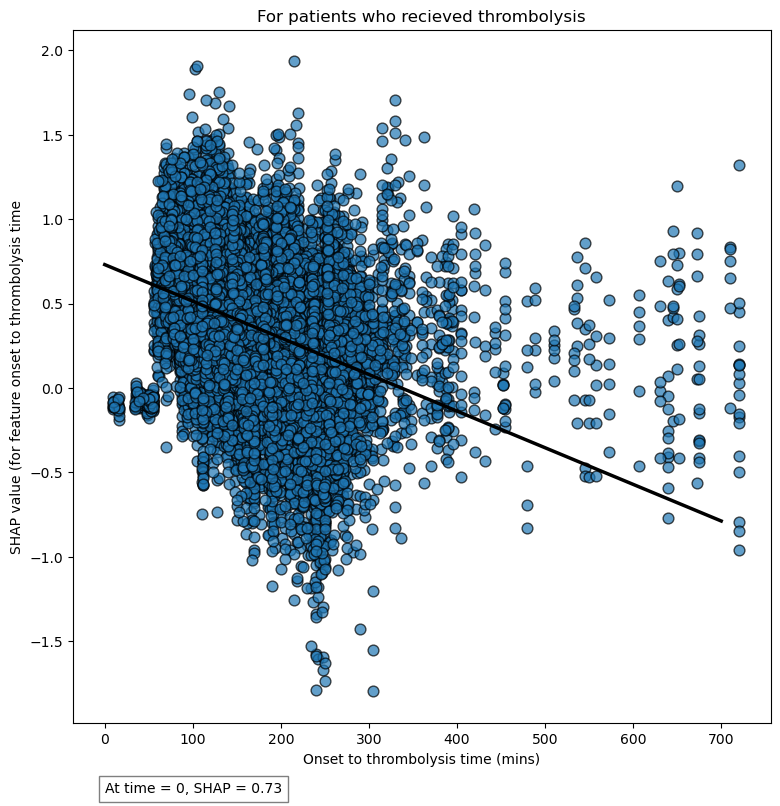

In [25]:
# Generate data
x = df_test_ivt_shap["onset_to_thrombolysis_time"]
y = df_test_ivt_shap["shap_ivt"]

# Initialize layout
fig, ax = plt.subplots(figsize = (9, 9))

# Add scatterplot
ax.scatter(x, y, s=60, alpha=0.7, edgecolors="k")

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
b, a = np.polyfit(x, y, deg=1)

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(-0, 700, num=100)

# Plot regression line
ax.plot(xseq, a + b * xseq, color="k", lw=2.5);

ax.set_xlabel("Onset to thrombolysis time (mins)")
ax.set_ylabel("SHAP value (for feature onset to thrombolysis time")
ax.set_title("For patients who recieved thrombolysis")

ax.text(0,-2.4, f"At time = 0, SHAP = {round(a,3)}", bbox=dict(facecolor='white', alpha=0.5))

Repeat the plot, show the individual mRS thresholds (by colour, and calculate and plot a separate line)

Text(0, -3.0, 'At time = 0:\n\nSHAP using threshold mRS0 = 0.969\nSHAP using threshold mRS1 = 0.72\nSHAP using threshold mRS2 = 0.82\nSHAP using threshold mRS3 = 0.804\nSHAP using threshold mRS4 = 0.575\nSHAP using threshold mRS5 = 0.495')

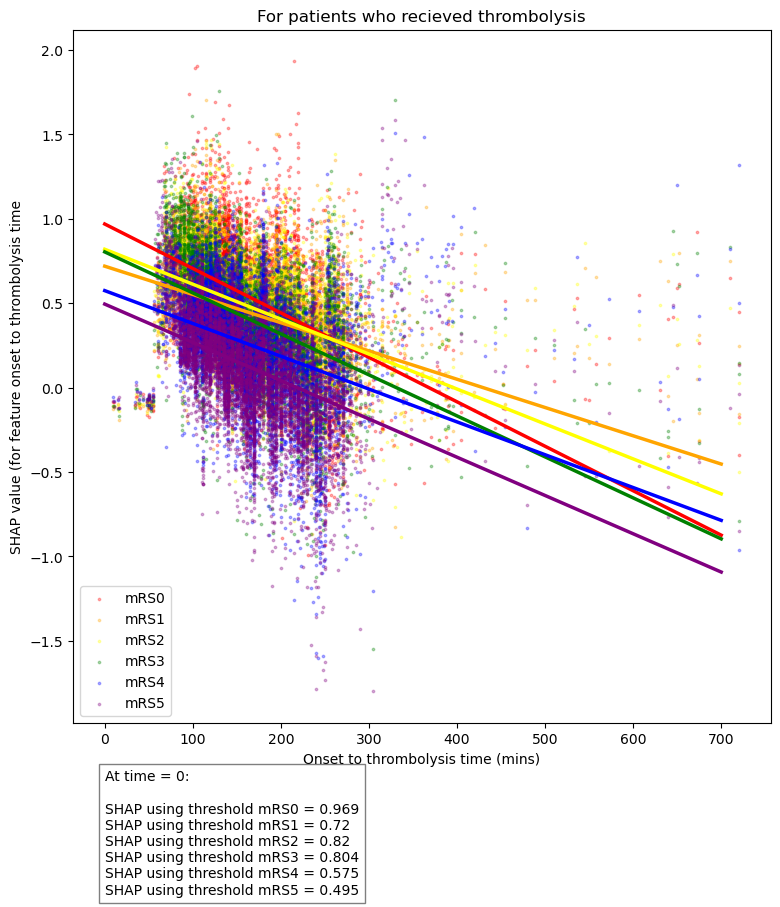

In [26]:
# Initialize layout
fig, ax = plt.subplots(figsize = (9, 9))
color = ["red", "orange", "yellow", "green", "blue", "purple"]
text = "At time = 0:\n"
label = ["mRS0","mRS1","mRS2","mRS3","mRS4","mRS5"]
for t in range(6):
    mask = df_test_ivt_shap["mRS_threshold"] == t
    # Generate data
    x = df_test_ivt_shap["onset_to_thrombolysis_time"][mask]
    y = df_test_ivt_shap["shap_ivt"][mask]

    # Add scatterplot
    ax.scatter(x, y, s=3, alpha=0.3, color = color[t],label=label[t])#, edgecolors="k")

    # Fit linear regression via least squares with numpy.polyfit
    # It returns an slope (b) and intercept (a)
    # deg=1 means linear fit (i.e. polynomial of degree 1)
    b, a = np.polyfit(x, y, deg=1)

    # Create sequence of 100 numbers from 0 to 100 
    xseq = np.linspace(-0, 700, num=100)

    # Plot regression line
    ax.plot(xseq, a + b * xseq, color=color[t], lw=2.5);

    ax.set_xlabel("Onset to thrombolysis time (mins)")
    ax.set_ylabel("SHAP value (for feature onset to thrombolysis time")
    ax.set_title("For patients who recieved thrombolysis")

    ax.legend()

    text = text + f"\nSHAP using threshold mRS{t} = {round(a,3)}"
ax.text(0,-3.0, text, bbox=dict(facecolor='white', alpha=0.5))

Repeat, and restrict the time at 300

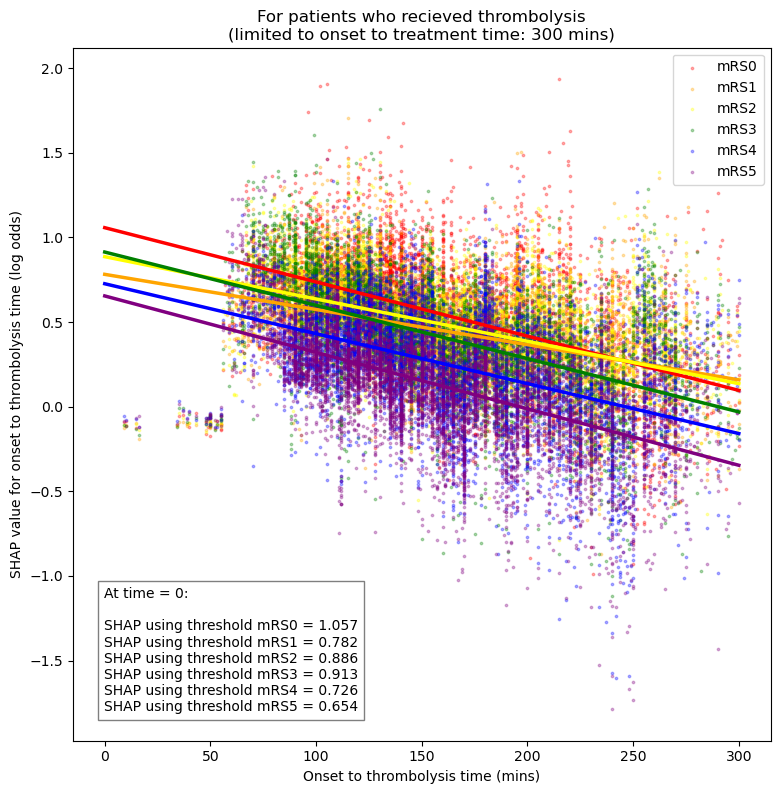

In [27]:
max_treatment_time = 300

# Initialize layout
fig, ax = plt.subplots(figsize = (9, 9))
color = ["red", "orange", "yellow", "green", "blue", "purple"]
text = "At time = 0:\n"
label = ["mRS0","mRS1","mRS2","mRS3","mRS4","mRS5"]
for t in range(6):
    mask1 = df_test_ivt_shap["mRS_threshold"] == t
    mask2 = df_test_ivt_shap["onset_to_thrombolysis_time"] <= max_treatment_time
    mask = mask1 * mask2

    # Generate data
    x = df_test_ivt_shap["onset_to_thrombolysis_time"][mask]
    y = df_test_ivt_shap["shap_ivt"][mask]

    # Add scatterplot
    ax.scatter(x, y, s=3, alpha=0.3, color = color[t],label=label[t])#, edgecolors="k")

    # Fit linear regression via least squares with numpy.polyfit
    # It returns an slope (b) and intercept (a)
    # deg=1 means linear fit (i.e. polynomial of degree 1)
    b, a = np.polyfit(x, y, deg=1)

    # Create sequence of 100 numbers from 0 to 100 
    xseq = np.linspace(-0, max_treatment_time, num=100)

    # Plot regression line
    ax.plot(xseq, a + b * xseq, color=color[t], lw=2.5);

    ax.set_xlabel("Onset to thrombolysis time (mins)")
    ax.set_ylabel("SHAP value for onset to thrombolysis time (log odds)")
    ax.set_title(f"For patients who recieved thrombolysis"
                 f"\n(limited to onset to treatment time: {max_treatment_time} mins)")

    ax.legend()

    text = text + f"\nSHAP using threshold mRS{t} = {round(a,3)}"
ax.text(-0.4, -1.8, text, bbox=dict(facecolor='white', alpha=0.5))

filename = (f'{paths.output_save_path}{paths.notebook}_{paths.model_text}_'
            f'ott_featurevalue_vs_shapvalue_bymRSthreshold.jpg')
plt.savefig(filename, dpi=300)


Want to fit to the improvement due to thrombolysis.

To do this, calculate the SHAP value for feature Onset to thrombolysis time, for the patients not recieving thrombolysis. Calculate the average SHAP value for those patients without thrombolysis (a value for each threshold).

For each patient calculate the improvement due to thrombolysis by subtracting the average SHAP value from each patient (wrt threshold).

Recalculate the linear regression (per threshold), fitting to the SHAP value minus the average SHAP value for those patients without thrombolysis

In [ ]:
mask_test_not_get_ivt = X_test["onset_to_thrombolysis_time"] == -100
df_test_not_ivt_shap = create_df(X_test, mask_test_not_get_ivt)

In [29]:
df_test_not_ivt_shap_reformatted = pd.DataFrame()

df_test_not_ivt_shap_reformatted["patient_id"] = (
                            mask_test_not_get_ivt.index[mask_test_not_get_ivt])

for t in range(6):
    mask = (df_test_not_ivt_shap["mRS_threshold"]==t)

    df_test_not_ivt_shap_reformatted[f"mRS{t}"] = (
                                    df_test_not_ivt_shap["shap_ivt"][mask])

columns = ["mRS0","mRS1","mRS2","mRS3","mRS4","mRS5"]
df_test_not_ivt_mean_shap = df_test_not_ivt_shap_reformatted[columns].mean(axis=0)

df_test_not_ivt_mean_shap

,patient_id,mRS0,mRS1,mRS2,mRS3,mRS4,mRS5
0,0,-0.099839,-0.166807,-0.166404,-0.126442,-0.050259,-0.062451
1,1,-0.023642,-0.047152,-0.052457,-0.002041,0.007191,-0.048604
2,2,-0.054853,-0.011488,0.017904,-0.018028,0.015476,0.007878
3,3,-0.073782,-0.061943,-0.071805,-0.054383,-0.029267,-0.056903
4,4,-0.141552,-0.065017,-0.052700,-0.038531,-0.025879,-0.027960
...,...,...,...,...,...,...,...
26768,33663,-0.018078,-0.047805,-0.034776,-0.043087,-0.053411,-0.047012
26769,33664,-0.029461,-0.046907,-0.041286,-0.012281,0.025063,-0.003881
26770,33665,-0.063849,-0.051523,-0.034569,0.000410,0.029581,0.010270
26771,33667,-0.084796,-0.095337,-0.091491,-0.080734,-0.051906,-0.074080


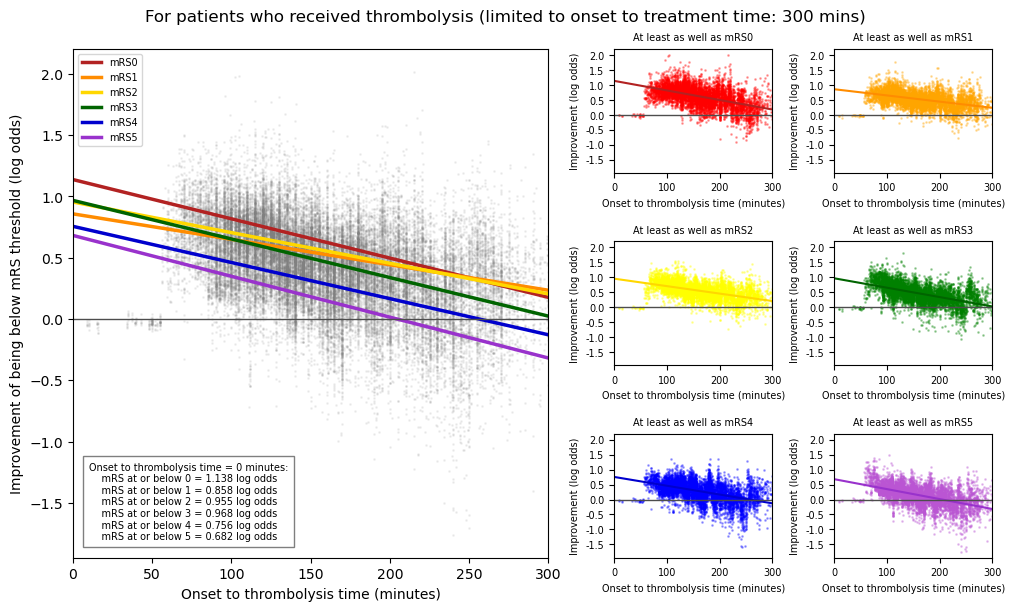

In [32]:
fig, ax = plt.subplot_mosaic(
    [
    ['main', 'mRS0', 'mRS1'],
    ['main', 'mRS2', 'mRS3'],
    ['main', 'mRS4', 'mRS5'],
    ],
    width_ratios=[3, 1, 1],
    layout='constrained',
    figsize=(10,6),
)

fig.suptitle(f"For patients who received thrombolysis"
                 f" (limited to onset to treatment time: {max_treatment_time} mins)")

max_treatment_time = 300


y_pos = np.array([-1.5,-1,-0.5,0,0.5,1,1.5,2])
handles = []
# Initialize layout
#fig, ax = plt.subplots(figsize = (9, 9))
point_color = ["red", "orange", "yellow", "green", "blue", "mediumorchid"]
line_color = ["firebrick", "darkorange", "gold", "darkgreen", "mediumblue", "darkorchid"]
text = "Onset to thrombolysis time = 0 minutes:"
label = ["mRS0","mRS1","mRS2","mRS3","mRS4","mRS5"]
for t in range(6):

    # Average SHAP for those not receive IVT
    shap_not_receive_ivt = df_test_not_ivt_mean_shap[f"mRS{t}"]

    mask1 = df_test_ivt_shap["mRS_threshold"] == t
    mask2 = df_test_ivt_shap["onset_to_thrombolysis_time"] <= max_treatment_time
    mask = mask1 * mask2

    # Generate data
    x = df_test_ivt_shap["onset_to_thrombolysis_time"][mask]
    y = df_test_ivt_shap["shap_ivt"][mask] - shap_not_receive_ivt

    # Add scatterplot
    ax['main'].scatter(x, y, s=1, color = 'grey', alpha=0.1)#, label=label[t])#, edgecolors="k")
 
    # Fit linear regression via least squares with numpy.polyfit
    # It returns an slope (b) and intercept (a)
    # deg=1 means linear fit (i.e. polynomial of degree 1)
    b, a = np.polyfit(x, y, deg=1)

    # Create sequence of 100 numbers from 0 to 100 
    xseq = np.linspace(0, max_treatment_time, num=100)

    # Plot regression line
    l, = ax['main'].plot(xseq, a + b * xseq, color=line_color[t], lw=2.5, label=label[t]);
    #handles.append(l)
    ax['main'].set_xlabel("Onset to thrombolysis time (minutes)")
    ax['main'].set_ylabel("Improvement of being below mRS threshold (log odds)")
    #ax['main'].set_title(f"For patients who recieved thrombolysis"
    #             f"\n(limited to onset to treatment time: {max_treatment_time} mins)")

    ax[f'mRS{t}'].scatter(x, y, s=1, alpha=0.3, color = point_color[t],label=label[t])
    ax[f'mRS{t}'].plot(xseq, a + b * xseq, color=line_color[t], lw=1.5)
    ax[f'mRS{t}'].set_title(f"At least as well as mRS{t}",fontsize=7)
    ax[f'mRS{t}'].set_xlabel("Onset to thrombolysis time (minutes)",fontsize=7)
    ax[f'mRS{t}'].set_ylabel(f"Improvement (log odds)",fontsize=7)
    ax[f'mRS{t}'].set_xlim(0,max_treatment_time)
    ax[f'mRS{t}'].plot([0,300],[0,0],c='0.3',linewidth=1)

    text = text + f"\n    mRS at or below {t} = {round(a,3)} log odds"
ax['main'].text(10, -1.8, text, fontsize=7, bbox=dict(facecolor='white', alpha=0.5))
ax['main'].plot([0,300],[0,0],c='0.3',linewidth=1)

#ax.legend(['First line', 'Second line'])
#ax['main'].legend(handles=handles,framealpha=1)
ax['main'].legend(loc='upper left', prop = { "size": 7})#(label)#,framealpha=1)
#l.legend_elements(prop='colors', num=20)

#leg = ax['main'].get_legend()
#for t in range(6):
#    leg.legendHandles[t].set_color(line_color[t])

ax['main'].set_xlim(0,max_treatment_time)

#x_pos = ax['main'].get_xticklabels()
for t in range(6):
    ax[f'mRS{t}'].set_ylim(ax['main'].get_ylim())
    ax[f'mRS{t}'].set_yticks(y_pos)
    ax[f'mRS{t}'].set_yticklabels(y_pos,fontsize=7)
#    ax[f'mRS{t}'].set_xticklabels(fontsize=7)
    ax[f'mRS{t}'].tick_params(axis='x', labelsize=7)

filename = (f'{paths.output_save_path}{paths.notebook}_{paths.model_text}_'
            f'improvement_logodds_bymRSthreshold_subplots_avenoivt.jpg')
plt.savefig(filename, dpi=300)

fig.canvas.draw()

Want to fit to the improvement due to thrombolysis.

To do this, calculate the SHAP value for feature Onset to thrombolysis time, by setting those patients that have thrombolysis as not having it, and getting new SHAP predictions but with all other features the same. We could then subtract that SHAP from the patients SHAP as having thrombolysis. So do it for each patient separately.

For each patient calculate the improvement due to thrombolysis by subtracting their SHAP value as if not have thrtombolysis (wrt threshold).

Recalculate the linear regression (per threshold), fitting to the SHAP value minus the average SHAP value for those patients without thrombolysis

In [33]:
X_test_not_get_ivt = X_test.copy(deep=True)
X_test_not_get_ivt["onset_to_thrombolysis_time"] = -100
shap_values_test_no_ivt_threshold = []

# Loop through thresholds folds. Get model and get SHAP for patients not getting IVT
for t in range(6):  
    model = model_threshold[t]
    
    # Set up explainer using the model and feature values from training set
    explainer = shap.TreeExplainer(model, X_train)

    # Get (and store) Shapley values along with base and feature values
    shap_values_test_extended_no_ivt = explainer(X_test_not_get_ivt)
    shap_values_test_no_ivt_threshold.append(shap_values_test_extended_no_ivt.values)

 98%|===================| 33055/33670 [00:42<00:00]        

In [34]:
def create_df_with_without_ivt(X_data, shap_values_threshold, shap_values_no_ivt_threshold):
    # initiate a Dataframe with the required columns 
    columns=(["patient_id","stroke_severity", "mRS_threshold", "shap_ivt", 
              "shap_not_ivt", "shap_ivt_improvement",
              "onset_to_thrombolysis_time"])
    df = pd.DataFrame(columns=columns)
                
    # Create mask for patients that recieve thrombolysis
    mask_get_ivt = X_data["onset_to_thrombolysis_time"]>-100

    # Go through each mRS threshold and create a dataframe, then append it (add rows) to the main dataframe.
    for t in range(6):
        df_temp=pd.DataFrame(data=mask_get_ivt.index[mask_get_ivt], 
                            columns=["patient_id"])
        # Store the mRS threshold
        df_temp[f"mRS_threshold"] = t
        # Get SHAP values for this threshold
        sv = shap_values_threshold[t]
        sv_not = shap_values_no_ivt_threshold[t]

        # Store the SHAP values for feature onset_to_thrombolysis_time
        df_temp["shap_ivt"] = sv[mask_get_ivt, ivt_loc]
        df_temp["shap_not_ivt"] = sv_not[mask_get_ivt, ivt_loc]
        # Store the feature values for feature onset_to_thrombolysis_time
        df_temp["onset_to_thrombolysis_time"] = (
                X_data["onset_to_thrombolysis_time"][mask_get_ivt].values)
        df_temp["stroke_severity"] = (
                X_data["stroke_severity"][mask_get_ivt].values)

        # Append rows to the main dataframe
        df = df.append(df_temp)

    df["shap_ivt_improvement"] = (df["shap_ivt"] - df["shap_not_ivt"])
    
    return(df)

In [35]:
df_test_ivt_and_no_ivt_shap = create_df_with_without_ivt(X_test, 
                shap_values_test_threshold, shap_values_test_no_ivt_threshold)
df_test_ivt_and_no_ivt_shap

,patient_id,stroke_severity,mRS_threshold,shap_ivt,shap_not_ivt,shap_ivt_improvement,onset_to_thrombolysis_time
0,6,5,0,0.652253,-0.105898,0.758151,90.0
1,7,9,0,0.336578,-0.047164,0.383743,183.0
2,12,10,0,1.180103,-0.118089,1.298192,187.0
3,15,5,0,0.182453,-0.096657,0.279110,232.0
4,16,8,0,0.737651,-0.130943,0.868594,165.0
...,...,...,...,...,...,...,...
6892,33652,24,5,0.395544,-0.075698,0.471242,132.0
6893,33656,2,5,0.017779,-0.025629,0.043408,118.0
6894,33657,10,5,0.476715,-0.110052,0.586766,180.0
6895,33666,12,5,0.385144,-0.038941,0.424085,124.0


### Repeat for training set, as want the SHAP improvement due to IVT for the training set too, as will use this as the target feature in a later XGBoost model (below)

In [36]:
X_train_no_ivt = X_train.copy(deep=True)
X_train_no_ivt["onset_to_thrombolysis_time"] = -100
shap_values_train_no_ivt_threshold = []

# Loop through thresholds folds. Get model and get SHAP for patients not getting IVT
for t in range(6):
    model = model_threshold[t]
    
    # Set up explainer using the model and feature values from training set
    explainer = shap.TreeExplainer(model, X_train)

    # Get (and store) Shapley values along with base and feature values
    shap_values_train_extended_no_ivt = explainer(X_train_no_ivt)
    shap_values_train_no_ivt_threshold.append(shap_values_train_extended_no_ivt.values)

# Create a dataframe for the patients in the training set that got IVT (as need the onset to treatment time). 
# A row per patient. Store the features needed for the plot, and the SHAP for getting IVT at their onset to treatment time, and their SHAP if not get IVT.
df_train_ivt_and_no_ivt_shap = create_df_with_without_ivt(X_train,
                shap_values_train_threshold, shap_values_train_no_ivt_threshold)
df_train_ivt_and_no_ivt_shap.head()

100%|===================| 134555/134677 [02:56<00:00]        

Now back to plotting the test set results

In [ ]:
def create_mosaic_plot(df_test_ivt_and_no_ivt_shap, max_treatment_time, filename_suffix):
    
    fig, ax = plt.subplot_mosaic(
        [
        ['main', 'mRS0', 'mRS1'],
        ['main', 'mRS2', 'mRS3'],
        ['main', 'mRS4', 'mRS5'],
        ],
        width_ratios=[3, 1, 1],
        layout='constrained',
        figsize=(10,6),
    )
    plt.rcParams['legend.title_fontsize'] = 'x-small'

    fig.suptitle(f"Estimated improvement in discharge disability that's associated with thrombolysis treatment"
                f"\n(limited to patients who received thrombolysis within {max_treatment_time} minutes of stroke onset)")

    handles = []

    point_color = ["red", "orange", "yellow", "green", "blue", "mediumorchid"]
    line_color = ["firebrick", "darkorange", "gold", "darkgreen", "mediumblue", "darkorchid"]
    text = "With 0 minutes onset to thrombolysis time:"
    label = ["mRS0","mRS1","mRS2","mRS3","mRS4","mRS5"]
    for t in range(6):

        mask = df_test_ivt_and_no_ivt_shap["mRS_threshold"] == t

        # Generate data
        x = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"][mask]
        y = df_test_ivt_and_no_ivt_shap["shap_ivt_improvement"][mask]

        # Add scatterplot
        ax['main'].scatter(x, y, s=1, color = 'grey', alpha=0.1)#, label=label[t])#, edgecolors="k")
    
        # Fit linear regression via least squares with numpy.polyfit
        # It returns an slope (b) and intercept (a)
        # deg=1 means linear fit (i.e. polynomial of degree 1)
        b, a = np.polyfit(x, y, deg=1)

        # Create sequence of 100 numbers from 0 to 100 
        xseq = np.linspace(0, max_treatment_time, num=100)

        #ax['main'].set_title(f"For patients who recieved thrombolysis"
        #             f"\n(limited to onset to treatment time: {max_treatment_time} mins)")

        ax[f'mRS{t}'].scatter(x, y, s=1, alpha=0.3, color = point_color[t],label=label[t])
        ax[f'mRS{t}'].plot(xseq, a + b * xseq, color=line_color[t], lw=1.5)
        ax[f'mRS{t}'].set_title(f"mRS at or below {t}\n(No effect at {round(-a/b)} minutes)",fontsize=7)
        ax[f'mRS{t}'].set_xlabel("Onset to thrombolysis time (minutes)",fontsize=7)
        ax[f'mRS{t}'].set_ylabel(f"Improvement (log odds)",fontsize=7)
        ax[f'mRS{t}'].set_xlim(0,max_treatment_time)
        ax[f'mRS{t}'].plot([0,300],[0,0],c='0.3',linewidth=1)

        text = text + f"\n    mRS at or below {t} = {round(a,3)} log odds"

    # Fit linear regression via least squares with numpy.polyfit
    # It returns an slope (b) and intercept (a)
    # deg=1 means linear fit (i.e. polynomial of degree 1)
    x = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"]
    y = df_test_ivt_and_no_ivt_shap["shap_ivt_improvement"]
    b, a = np.polyfit(x, y, deg=1)

    # Plot regression line
    l, = ax['main'].plot(xseq, a + b * xseq, color="grey", lw=2.5, label="All mRS thresholds");

    ax['main'].text(10, -1.8, text, fontsize=7, bbox=dict(facecolor='white', alpha=0.5))
    ax['main'].plot([0,300],[0,0],c='0.3',linewidth=1)

    #ax.legend(['First line', 'Second line'])
    #ax['main'].legend(handles=handles,framealpha=1)
    ax['main'].legend(title="mRS threshold",fontsize='small', loc='upper left', prop = { "size": 7})#(label)#,framealpha=1)
    #handles.append(l)
    ax['main'].set_xlabel("Onset to thrombolysis time (minutes)")
    ax['main'].set_ylabel("Estimated improvement associated with treatment\n(log odds improvements in being below mRS threshold)")
    ylim_main = ax['main'].get_ylim()
    yticks_main = ax['main'].get_yticks()

    ax['main'].set_xlim(0,max_treatment_time)

    #l.legend_elements(prop='colors', num=20)

    #leg = ax['main'].get_legend()
    #for t in range(6):
    #    leg.legendHandles[t].set_color(line_color[t])

    #x_pos = ax['main'].get_xticklabels()
    for t in range(6):
        ax[f'mRS{t}'].set_yticks(yticks_main)
        ax[f'mRS{t}'].set_yticklabels(yticks_main,fontsize=7)
        ax[f'mRS{t}'].set_ylim(ylim_main)
    #    ax[f'mRS{t}'].set_xticklabels(fontsize=7)
        ax[f'mRS{t}'].tick_params(axis='x', labelsize=7)

    filename = (f'{paths.output_save_path}{paths.notebook}_{paths.model_text}_'
                f'improvement_logodds_bymRSthreshold_subplots{filename_suffix}.jpg')
    plt.savefig(filename, dpi=300)

    fig.canvas.draw()

    return()

For both nLVO and LVO patients, fitting linear regression to only patients treated within a max time.

In [ ]:
max_treatment_time = 300
mask = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"] <= max_treatment_time

create_mosaic_plot(df_test_ivt_and_no_ivt_shap[mask], max_treatment_time, "_nLVO_LVO")

Repeat the plot for two subpopulations: LVO vs non-LVO (using <= NIHSS 10 and >= NIHSS 11 as a surrogate to identify an LVO)

For each thrombolysed patient we calculate an estimated thrombolysis treatment effect: thrombolysis SHAP with treatment - thrombolysis SHAP if no treatment was given (by changing just thrombolysis and re-predicting thrombolysis SHAP). I've suggested we use this in the regression as well rather than using untreated thrombolysis from different patients.

We then build a XGBoost regression model to predict thrombolysis treatment effect. Then add SHAP to that, and we see what patient features improve benefit from thrombolysis, and which reduce.
We might also want to just look at characteristics of patients with a negative treatment effect, vs those with a positive treatment effect.

Already have mask_test_get_ivt & mask_train_get_ivt to use with X_train[mask_train_get_ivt] and X_test[mask_test_get_ivt]

For just nLVO patients

In [ ]:
nonlvo_threshold = 10
mask1 = df_test_ivt_and_no_ivt_shap["stroke_severity"] <= nonlvo_threshold

mask = mask1 * mask2

create_mosaic_plot(df_test_ivt_and_no_ivt_shap[mask], max_treatment_time, "_nLVO")

For just LVO patients

In [ ]:
mask1 = df_test_ivt_and_no_ivt_shap["stroke_severity"] > nonlvo_threshold
mask = mask1 * mask2

create_mosaic_plot(df_test_ivt_and_no_ivt_shap[mask], max_treatment_time, "_LVO")

# NEED TO WORK OUT WHAT HAPPENONG ONWARDS, AND IF NEED FOR HTE GITHUB REPOSITORY

In [44]:
X_train_get_ivt = X_train[mask_train_get_ivt]
X_test_get_ivt = X_test[mask_test_get_ivt]

In [52]:
t=0

# get the target feature: the SHAP for improvement due to IVT 
# (wrt the mRS threshold)
mask_train_mrs = df_train_ivt_and_not_shap["mRS_threshold"] == t
y_train_get_ivt = df_train_ivt_and_not_shap["shap_ivt_improvement"][mask_train_mrs]
mask_test_mrs = df_test_ivt_and_not_shap["mRS_threshold"] == t 
y_test_get_ivt = df_test_ivt_and_not_shap["shap_ivt_improvement"][mask_test_mrs]

In [57]:
X_test.index.values.shape

(33670,)

In [56]:
df_test_ivt_and_not_shap[mask_test_mrs]["patient_id"]

0           6
1           7
2          12
3          15
4          16
        ...  
6892    33652
6893    33656
6894    33657
6895    33666
6896    33669
Name: patient_id, Length: 41382, dtype: object

In [ ]:
r_square_threshold = []
roc_auc_ovr_threshold = []
accuracy_threshold = []
error_within_one_threshold = []
feature_importance_threshold = []
y_probs_threshold = []
y_pred_threshold = []
model_threshold = []
shap_values_extended_si_threshold = []
shap_values_si_threshold = []

# Loop through thresholds folds
for t in range(6):

    # set string for output
    binary_target_feature = f'binary_{t}'

    # get the target feature: the SHAP for improvement due to IVT 
    # (wrt the mRS threshold)
    mask_train_mrs = df_train_ivt_and_not_shap["mRS_threshold"] == t
    y_train_get_ivt = df_train_ivt_and_not_shap["shap_ivt_improvement"][mask_train_mrs]
    mask_test_mrs = df_test_ivt_and_not_shap["mRS_threshold"] = t 
    y_test_get_ivt = df_test_ivt_and_not_shap["shap_ivt_improvement"][mask_test_mrs]

    #check the patient ID match up between these two data sources


    # Model filename
    filename = (f'{paths.model_save_path}'
                f'{paths.notebook}_{paths.model_text}_{t}_shapimprovment.p')
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
            model_threshold.append(model)        
    else:
        # Define and Fit model
        model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5,
                              tree_method='gpu_hist')
        model.fit(X_train, y_train)
        model_threshold.append(model)

        # Save using pickle
        filename = (f'{paths.model_save_path}'
                    f'{paths.notebook}_{paths.model_text}_{t}_shapimprovment.p')
        with open(filename, 'wb') as filehandler:
            pickle.dump(model_threshold[t], filehandler)
    
    # Get target categories from model
    classes = model.classes_

    # Get and store predicted probabilities
    y_probs = model.predict_proba(X_test)
    y_probs_threshold.append(y_probs)#[:,1])

    # Get and store predicted class
    y_pred = model.predict(X_test)
    y_pred_threshold.append(y_pred)

    # Calculate ROC AUC for multiclass models, using One vs Rest
    roc_auc_ovr = roc_auc_score(y_test, y_probs[:,1], labels = classes, 
                                multi_class = 'ovr', average = 'macro')
    roc_auc_ovr_threshold.append(roc_auc_ovr)

    # Calculate error
    y_error = y_test - y_pred
    accuracy = np.mean(y_error==0)
    accuracy_threshold.append(accuracy)

    error_within_one = np.mean(np.abs(y_error)<=1)
    error_within_one_threshold.append(error_within_one)

    # Get and store feature importances
    feature_importance = model.feature_importances_
    feature_importance_threshold.append(feature_importance)


    # Set filename
    shap_filename = (f'{paths.output_save_path}{paths.notebook}_{paths.model_text}'
                f'_{t}_shapimprovment_shap_values_extended.p')
    # Check if exists
    file_exists = exists(shap_filename)

    if file_exists:
        # Load explainer
        with open(shap_filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
            shap_values = shap_values_extended.values
            shap_values_si_threshold.append(shap_values)     
    else:
        # Calculate SHAP values

        # Set up explainer using the model and feature values from training set
        explainer = shap.TreeExplainer(model, X_train)

        # Get and store SHAP values
        # Set up explainer using the model and feature values from training set
        explainer = shap.TreeExplainer(model, X_train)

        # Get (and store) Shapley values along with base and feature values
        shap_values_extended = explainer(X_test)
        shap_values_extended_si_threshold.append(shap_values_extended)
        # Shap values exist for each classification in a Tree
        # We are interested in 1=give thrombolysis (not 0=not give thrombolysis)
        shap_values = shap_values_extended.values
        shap_values_si_threshold.append(shap_values)     

        explainer_filename = (f'{paths.output_save_path}{paths.notebook}_'
                                f'{paths.model_text}_{t}_shapimprovment_shap_explainer.p')

        # Save explainer using pickle
        with open(explainer_filename, 'wb') as filehandler:
            pickle.dump(explainer, filehandler)
            
        # Save shap values extendedr using pickle
        with open(shap_filename, 'wb') as filehandler:
            pickle.dump(shap_values_extended, filehandler)


In [ ]:
t=1
mask = (df_not_ivt_shap["mRS_threshold"]==t)
#

In [ ]:
df_not_ivt_shap["shap_ivt"][mask]

0       -0.166807
1       -0.047152
2       -0.011488
3       -0.061943
4       -0.065017
           ...   
26768   -0.047805
26769   -0.046907
26770   -0.051523
26771   -0.095337
26772   -0.032208
Name: shap_ivt, Length: 26773, dtype: float64

In [ ]:
df_not_ivt_shap_hist = pd.DataFrame()
#            columns=["patient_id", "mRS0",_"mRS1","mRS2","mRS3","mRS4","mRS5"])

df_not_ivt_shap_hist["patient_id"] = mask_not_get_ivt.index[mask_not_get_ivt]
df_not_ivt_shap_hist

,patient_id
0,0
1,1
2,2
3,3
4,4
...,...
26768,33663
26769,33664
26770,33665
26771,33667


In [ ]:
t=0
mask = (df_not_ivt_shap["mRS_threshold"]==t) * 1


In [ ]:
df_not_ivt_shap["shap_ivt"][mask]

1   -0.023642
1   -0.047152
1   -0.052457
1   -0.002041
1    0.007191
       ...   
0   -0.166807
0   -0.166404
0   -0.126442
0   -0.050259
0   -0.062451
Name: shap_ivt, Length: 963828, dtype: float64

In [ ]:
df_not_ivt_shap_hist[f"mRS{t}"] = df_not_ivt_shap["shap_ivt"][mask]

df_not_ivt_shap_hist

In [ ]:
df_not_ivt_shap_hist = pd.DataFrame()
#            columns=["patient_id", "mRS0","mRS1","mRS2","mRS3","mRS4","mRS5"])

df_not_ivt_shap_hist["patient_id"] = mask_not_get_ivt.index[mask_not_get_ivt]
for t in range(6):
    mask = (df_not_ivt_shap["mRS_threshold"]==t)

    df_not_ivt_shap_hist[f"mRS{t}"] = df_not_ivt_shap["shap_ivt"][mask]

df_not_ivt_shap_hist

,patient_id,mRS0,mRS1,mRS2,mRS3,mRS4,mRS5
0,0,-0.099839,-0.166807,-0.166404,-0.126442,-0.050259,-0.062451
1,1,-0.023642,-0.047152,-0.052457,-0.002041,0.007191,-0.048604
2,2,-0.054853,-0.011488,0.017904,-0.018028,0.015476,0.007878
3,3,-0.073782,-0.061943,-0.071805,-0.054383,-0.029267,-0.056903
4,4,-0.141552,-0.065017,-0.052700,-0.038531,-0.025879,-0.027960
...,...,...,...,...,...,...,...
26768,33663,-0.018078,-0.047805,-0.034776,-0.043087,-0.053411,-0.047012
26769,33664,-0.029461,-0.046907,-0.041286,-0.012281,0.025063,-0.003881
26770,33665,-0.063849,-0.051523,-0.034569,0.000410,0.029581,0.010270
26771,33667,-0.084796,-0.095337,-0.091491,-0.080734,-0.051906,-0.074080


Text(0.5, 1.0, 'bars with legend')

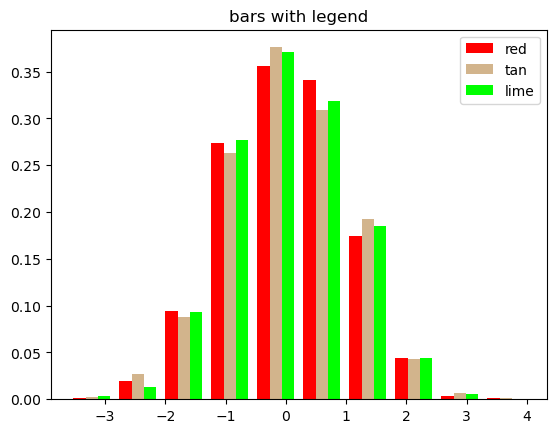

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(19680801)

n_bins = 10
x = np.random.randn(1000, 3)

fig, ax = plt.subplots()

colors = ['red', 'tan', 'lime']
ax.hist(x, n_bins, density=True, histtype='bar', color=colors, label=colors)
ax.legend(prop={'size': 10})
ax.set_title('bars with legend')

In [ ]:
x.shape

(1000, 3)

In [ ]:
df_not_ivt_shap_hist

,patient_id,mRS0,mRS1,mRS2,mRS3,mRS4,mRS5
0,0,-0.099839,-0.166807,-0.166404,-0.126442,-0.050259,-0.062451
1,1,-0.023642,-0.047152,-0.052457,-0.002041,0.007191,-0.048604
2,2,-0.054853,-0.011488,0.017904,-0.018028,0.015476,0.007878
3,3,-0.073782,-0.061943,-0.071805,-0.054383,-0.029267,-0.056903
4,4,-0.141552,-0.065017,-0.052700,-0.038531,-0.025879,-0.027960
...,...,...,...,...,...,...,...
26768,33663,-0.018078,-0.047805,-0.034776,-0.043087,-0.053411,-0.047012
26769,33664,-0.029461,-0.046907,-0.041286,-0.012281,0.025063,-0.003881
26770,33665,-0.063849,-0.051523,-0.034569,0.000410,0.029581,0.010270
26771,33667,-0.084796,-0.095337,-0.091491,-0.080734,-0.051906,-0.074080


Text(0.5, 1.0, 'Frequency of SHAP values for each mRS threshold')

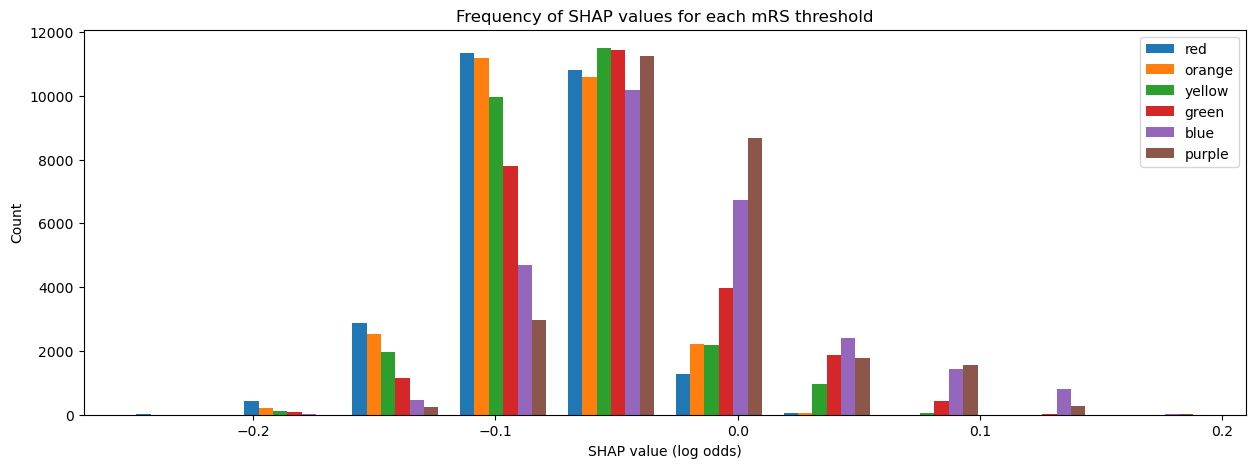

In [ ]:
#fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)
fig, ax = plt.subplots(figsize=(15, 5))
colors = ["red","orange","yellow","green","blue","purple"]
label = ["mRS0","mRS1","mRS2","mRS3","mRS4","mRS5"]
ax.hist(np.array(df_not_ivt_shap_hist[label]), 10, histtype='bar', label=colors)#color=colors, 
ax.legend(prop={'size': 10})
ax.set_xlabel("SHAP value (log odds)")
ax.set_ylabel("Count")
ax.set_title('Frequency of SHAP values for each mRS threshold')

In [ ]:
np.array(df_not_ivt_shap_hist[label]).shape

(26773, 6)

In [ ]:
df_not_ivt_shap["shap_ivt"].groupby(["mRS_threshold"])

KeyError: 'mRS_threshold'

import seaborn as sns
%matplotlib inline

sns.heatmap(df_ivt_shap[["shap_ivt","onset_to_thrombolysis_time"]], annot=True)

In [ ]:
model = LinearRegression(df_ivt_shap["shap_ivt"],df_ivt_shap["onset_to_thrombolysis_time"])

## Assess accuracy of model (and consistency across k-folds)
Look at accuracy in:
1. Accuracy (% correct)
1. Confusion matrix
2. ROCAUC

# Get average result from all k-fold splits

In [ ]:
accuracy_mean = np.mean(accuracy_kfold)
error_within_one_mean = np.mean(error_within_one_kfold)

print (f'All features, accuracy: {accuracy_mean:0.3f} '
       f'(std across {n_kfold} kfolds: {np.std(accuracy_kfold):0.3f})')

print (f'All features, accuracy within one: {error_within_one_mean:0.3f} '
       f'(std across {n_kfold} kfolds: {np.std(error_within_one_kfold):0.3f})')

Look at confusion matrix across the kfolds

Resource (subplots with imshow): https://stackoverflow.com/questions/18266642/multiple-imshow-subplots-each-with-colorbar

In [ ]:
# Define for the figure
nrows = 1
ncols = n_kfold
fig, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(15, 10))

if ncols > 1:
    fig.suptitle('Confusion matrices (per kfold)', fontsize=10)


# Set figure width relative to the number of kfolds
width = 20 * (n_kfold/5)
fig.set_size_inches(width,5)

# Legend height
shrink = 0.5

row = 0
col = 0

# Loop through the kfolds, subplot per kfold
for k in range(n_kfold):
    # Get axes
    if col > 1:
        ax = axs[col] # not take row argument as that only has 1 value, so axs is 1D
    else:
        ax = axs
        
    # Set axis title
    ax.set_title(f'Kfold {k+1}')

    # Get k fold split
    (X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                      test_data_kfold[k],
                                                      'discharge_disability')
    # Calculate values for confusion matrix
    cm = confusion_matrix(y_test, y_pred_kfold[k])

    # Visualize the confusion matrix with colors
    heatmap = ax.imshow(cm, cmap=plt.cm.Blues, origin='lower')
    plt.colorbar(heatmap, shrink=shrink, ax=ax, alpha=0.5, label='Count')

    #Add values to plot
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            ax.text(j, i, cm[i][j], ha='center', va='center', color='grey', 
                    size=8)

    ax.set_xlabel('Predicted value')
    ax.set_ylabel('Observed value')

    col += 1
    if col == ncols: 
        col = 0
        row += 1

plt.tight_layout()
# Make space for title
plt.subplots_adjust(top=1)

filename = (f'{paths.output_save_path}{paths.notebook}_{paths.model_text}_'
            f'confusion_matrices_per_kfold.jpg')
plt.savefig(filename, dpi=300)

plt.show()

## Multiclass ROC AUC

Calculate the overall ROC AUC for multiclass classification (a value per k-fold model)

In [ ]:
roc_auc_ovr_mean = np.mean(roc_auc_ovr_kfold)
print (f'ROCAUC (mean of {n_kfold} k-folds): {roc_auc_ovr_mean:0.3f}')
print (f'ROCAUC (std across {n_kfold} kfolds): {np.std(roc_auc_ovr_kfold):0.3f})')
print (f'ROCAUC (per kfold): {roc_auc_ovr_kfold}')

Plot histograms for each class (for each kfold model)

Using the functions that are slightly modified from the binary classifier case.

Resources:

https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a

https://github.com/vinyluis/Articles/blob/main/ROC%20Curve%20and%20ROC%20AUC/ROC%20Curve%20-%20Multiclass.ipynb



In [ ]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [ ]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [ ]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

ROC Curve - One vs Rest (OvR)
Compares each class with the rest of the classes

In [ ]:
classes = model.classes_

bins = [i/20 for i in range(20)] + [1]

# figure width to change with number of classes
width = 15 * (len(classes)/6)

# Create a figure per kfold
for k in range(n_kfold):
    # Plots the Probability Distributions and the ROC Curves One vs Rest
    plt.figure(figsize = (width, 8))
    fig.suptitle(f'K-fold {k}')
    roc_auc_ovr = {}

    # Get k fold split
    (X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                      test_data_kfold[k],
                                                      'discharge_disability')

    # With a subplot for each class
    for i in range(len(classes)):

        # Gets the class
        c = classes[i]
        
        # Prepares an auxiliar dataframe to help with the plots
        df_aux = pd.DataFrame()
        df_aux['class'] = [1 if y == c else 0 for y in y_test]
        df_aux['prob'] = y_probs_kfold[k][:, i]
        df_aux = df_aux.reset_index(drop = True)
        
        # Calculates the ROC AUC OvR
        roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

        # Plots the probability distribution for the class and the rest
        ax = plt.subplot(2, len(classes), i+1)
        sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', 
                     ax = ax, bins = bins)
        ax.set_title(f'Histogram (class {c})')
        ax.legend([f"Class: {c}", "Rest"])
        ax.set_xlabel(f"P(x = {c})")
        
        # Calculates the ROC Coordinates and plots the ROC Curves
        ax_bottom = plt.subplot(2, len(classes), i+len(classes)+1)
        tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
        plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
        ax_bottom.set_title(
                    f'AUCROC (class {c}): {round(roc_auc_ovr[c],3)}')
        
    plt.tight_layout()

    # Save
    filename = (f'{paths.output_save_path}{paths.notebook}_{paths.model_text}'
                f'_rocauc_ovr_kfold_{k}.jpg') 
    plt.savefig(filename, dpi=300)
    plt.show()


In [ ]:
if n_kfold > 1:
    classes = model.classes_

    bins = [i/20 for i in range(20)] + [1]

    # figure width to change with number of kfolds
    width = 15 * (n_kfold/5)

    # Create a figure per class
    for i in range(len(classes)):
        # Gets the class
        c = classes[i]
        
        # Plots the Probability Distributions and the ROC Curves One vs Rest
        plt.figure(figsize = (width, 8))
        fig.suptitle(f'Class {c}')
        roc_auc_ovr = {}

        # With a subplot for each kfold
        for k in range(n_kfold):
            
            # Get k fold split
            (X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                            test_data_kfold[k],
                                                            'discharge_disability')
            
            # Prepares an auxiliar dataframe to help with the plots
            df_aux = pd.DataFrame()
            df_aux['class'] = [1 if y == c else 0 for y in y_test]
            df_aux['prob'] = y_probs_kfold[k][:, i]
            df_aux = df_aux.reset_index(drop = True)
            
            # Calculates the ROC AUC OvR
            roc_auc_ovr[k] = roc_auc_score(df_aux['class'], df_aux['prob'])

            # Plots the probability distribution for the class and the rest
            ax = plt.subplot(2, n_kfold, k+1)
            sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', 
                        ax = ax, bins = bins)
            ax.set_title(f'Histogram (k-fold {k+1})')
            ax.legend([f"Class: {c}", "Rest"])
            ax.set_xlabel(f"P(x = {c})")
            
            # Calculates the ROC Coordinates and plots the ROC Curves
            ax_bottom = plt.subplot(2, n_kfold, k+1+n_kfold)
            tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
            plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
            ax_bottom.set_title(
                        f'AUCROC (k-fold {k+1}): {round(roc_auc_ovr[k],3)}')
            
        plt.tight_layout()

        # Save
        filename = (f'{paths.output_save_path}{paths.notebook}_{paths.model_text}'
                    f'_rocauc_ovr_class_{c}.jpg') 
        plt.savefig(filename, dpi=300)
        plt.show()
else:
    print('As this only uses one k-fold, this plot will not be created (it will'
        ' not provide any extra information over the set of subplots above)')


To interpret the above plots, think of the model as having 7 separate parts, each giving the probability of classifying an instance as each class (0, 1, 2, 3, 4, 5, 6).

These charts look at the performance of each of the model parts in isolation.

Left hand graph: Showing the probability of the model classifying an instance as class 0, for all of the instances that are a 0 (orange), for all the instances that are not 0 (blue). The blues are made up of the classes 1, 2, 3, 4, 5, 6.

Right hand graph: Showing the probability of the model classifying an instance as class 6, for all of the instances that are a 6 (orange), for all the instances that are not 6 (blue). The blues are made up of the classes 0, 1, 2, 3, 4, 5.

The model does not use a set threshold to determine the classification from a single graph (as in a binary label model). It instead classifies instances based on the class that has the maximum probability for that instance.

Therefore, for the LHS graph we can not know which of the instances end up getting a class 0 classification, as the threshold will differ for each instnace. So an orange point with 0.3 probability may get a 0 classification, and another orange point with 0.3 probability may not get a 0 classification.

Using ROC AUC to choose the features means we are choosing the feature which best differentiates each class from the others (a mean across all classes). It is not showing a model that has the best prediction (as it is not comparing the probabilities across the 7 classes).

The blue histogram in the OvR graphs represents the other 6 classes. When perform OvO the orange distribution is the same across all the graphs, but the blue is filtered to show just one of the other classes. Summing up all the OvR blue bits will give the OvO graph.

(see end of notebook for the OvO graphs)

### SHAP values
SHAP values give the contribution that each feature has on the models prediction, per instance. A SHAP value is returned for each feature, for each instance.

We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP values from XGBoost model are log odds ratios. A SHAP value is returned for each feature, for each instance, for each model (one per k-fold)

TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees. Using this we can calculate the SHAP values.

Either load from pickle (if file exists), or calculate.

In [ ]:
# Initialise empty lists
shap_values_extended_threshold = []
shap_values_threshold = []

# For each k-fold split
for t in range(7):
    # Set filename
    filename = (f'{paths.output_save_path}{paths.notebook}_{paths.model_text}'
                f'_shap_values_extended_{t}.p')
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
        # Load explainer
        with open(filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
            shap_values_extended_threshold.append(shap_values_extended)
            shap_values_threshold.append(shap_values_extended.values)
    else:
        # Calculate SHAP values
        # Get k fold split
        train = train_data_kfold[k]
        test = test_data_kfold[k]

        # Get X and y
        X_train = train.drop('discharge_disability', axis=1)
        X_test = test.drop('discharge_disability', axis=1)
        y_train = train['discharge_disability']
        y_test = test['discharge_disability']

        # Set up explainer using the model and feature values from training set
        explainer = shap.TreeExplainer(model_threshold[t], X_train)

        # Get (and store) Shapley values along with base and feature values
        shap_values_extended = explainer(X_test)
        shap_values_extended_threshold.append(shap_values_extended)
        # Shap values exist for each classification in a Tree
        # We are interested in 1=give thrombolysis (not 0=not give thrombolysis)
        shap_values = shap_values_extended.values
        shap_values_threshold.append(shap_values)        

        explainer_filename = (f'{paths.output_save_path}{paths.notebook}_'
                              f'{paths.model_text}_shap_explainer_{k}.p')

        # Save explainer using pickle
        with open(explainer_filename, 'wb') as filehandler:
            pickle.dump(explainer, filehandler)
            
        # Save shap values extendedr using pickle
        with open(filename, 'wb') as filehandler:
            pickle.dump(shap_values_extended, filehandler)
        
    # Print progress
    print (f'Completed {k+1} of {n_kfold}')

#### Get average SHAP values for each k-fold

For each k-fold split, calculate the mean SHAP value for each feature (across all instances), for each of the 7 disability discharge output values. 

The mean is calculated in three ways:

1. mean of raw values
2. mean of absolute values
3. absolute of mean of raw values


In a separate dataframe (df_mean_abs_shap), store the mean of the absolute SHAP values for each kfold, and also the min, median and max across the 5 kfolds (a row per feature). A dataframe per output class.

In [ ]:

# Initialise dictionary. Key name is output_class. Holds a list for dataframes
# for that class (for each kfold). The dataframe has a row per feature and a 
# column for the average SHAP values across all of the instances
dict_mean_abs_shap = {}
dict_list_of_df = {}

# For each output class
for c in range(n_classes):

    ## Initialise empty lists
    shap_values_mean_kfold = []
    # Initialise DataFrame (stores mean of the absolute SHAP values for each kfold)
    df_mean_abs_shap = pd.DataFrame()

    # For each k-fold split
    for k in range(n_kfold):
        # Calculate mean SHAP value for each feature (across all instances), for
        # this class
        shap_values = shap_values_kfold[k][:,:,c]
        df = pd.DataFrame(index=features_ohe)
        df['mean_shap'] = np.mean(shap_values, axis=0)
        df['abs_mean_shap'] = np.abs(df['mean_shap'])
        df['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
        df['rank'] = df['mean_abs_shap'].rank(ascending=False).values
        df.sort_index()
        shap_values_mean_kfold.append(df)

        # Store the mean of the absolute SHAP values in a dataframe (column for 
        # each k-fold split). 
        # Add more columns to this dataframe
        df_mean_abs_shap[f'{k}'] = df['mean_abs_shap']

    # For this class, df_mean_abs_shap has a column per kfold, row per feature, 
    # stores the mean of the absolute SHAP values across all instances.
    # Dictionary has a keyname per class, each storing a list of dataframes 
    # (a dataframe per kfold)
    dict_list_of_df[f'class{c}'] = shap_values_mean_kfold

    # Dictionary has a keyname per class, each storing a dataframe with a column 
    # per kfold (the mean of the absolute SHAPS across the instances). 

    # Create list of kfold indices
    cols = [str(i) for i in range(n_kfold)]

    df_mean_abs_shap['min'] = df_mean_abs_shap[cols].min(axis=1)
    df_mean_abs_shap['median'] = df_mean_abs_shap[cols].median(axis=1) 
    df_mean_abs_shap['max'] = df_mean_abs_shap[cols].max(axis=1)
    # Order features by their median value of the mean across the instances of their absolute SHAP
    df_mean_abs_shap.sort_values('median', inplace=True, ascending=False)


    # The 3 columns (min, median, max) that were in df_mean_abs_shap_summary are now in df_mean_abs_shap
    # Store the dataframe for this class (row per feature, column per kfold (and summary statistics) for SHAPs across all instances)
    dict_mean_abs_shap[f'class{c}'] = df_mean_abs_shap

For each output class, identify the 10 features with the highest SHAP values (in terms of the median of the kfolds of the mean of the absolute SHAP values)

Create a violin plot for these 10 features with the highest SHAP values.

A violin plot shows the distribution of the SHAP values for each feature across the 5 kfold splits. The bars show the min, median and max values for the feature, and the shaded area around the bars show the density of the data points.

In [ ]:
fig = plt.figure(figsize=(15, 10))

for c in range(n_classes):
    # Data for the violin plot (for this class)
    df_mean_abs_shap = dict_mean_abs_shap[f'class{c}']

    # Create list of kfold indices
    cols = [str(i) for i in range(n_kfold)]

    ax1 = fig.add_subplot(2,4,c+1)
    ax1.violinplot(df_mean_abs_shap[cols].iloc[:10].T,
                showmedians=True, widths=1)
    ax1.set_ylim(0)
    ax1.set_title(f'Disability discharge (mRS{c})')
    labels = df_mean_abs_shap.index[:10]
    ax1.set_xticks(np.arange(1, len(labels) + 1))
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.grid(which='both')
    ax1.set_ylabel(f'Median of the {n_kfold} k-folds\n[mean |Shap|] (log odds)')

plt.subplots_adjust(bottom=0.25, wspace=0.05)
    
plt.tight_layout(pad=2)

filename = (f'{paths.output_save_path}{paths.notebook}_{paths.model_text}'
            f'_shap_violin.jpg')

plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

### Compare top 10 SHAP and feature importance values

Compare the features (and their values) that make the top 10 when selected by either SHAP values, or feature importance values

In [ ]:
df_compare_shap_importance = pd.DataFrame()
df_compare_shap_importance['Importance (feature name)'] = \
                            df_feature_importance.index
df_compare_shap_importance['Importance (median value)'] = \
                            df_feature_importance['importance (median)'].values

for c in range(n_classes):
    # Data for the violin plot (for this class)
    df_compare_shap_importance[f'SHAP (feature name) [mRS{c}]'] = dict_mean_abs_shap[f'class{c}'].index
    df_compare_shap_importance[f'SHAP (median value) [mRS{c}]'] = dict_mean_abs_shap[f'class{c}']['median'].values
               
df_compare_shap_importance.head(10)

Plot all of the features, showing feature importance vs SHAP values.

In [ ]:
fig = plt.figure(figsize=(15, 10))

for c in range(n_classes):
    # Data for the violin plot (for this class)
    df_mean_abs_shap = dict_mean_abs_shap[f'class{c}']
    

    df_shap_importance = pd.DataFrame()
    df_shap_importance['Shap'] =  df_mean_abs_shap['median']
    df_shap_importance = df_shap_importance.merge(
        df_feature_importance['importance (median)'], left_index=True, right_index=True)
    df_shap_importance.rename(columns={'importance (median)': 'Importance'}, inplace=True)
    df_shap_importance.sort_values('Shap', inplace=True, ascending=False)

    ax1 = fig.add_subplot(2,4,c+1)
    ax1.scatter(df_shap_importance['Shap'],
                df_shap_importance['Importance'])
    ax1.set_title(f'Disability discharge (mRS{c})')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('SHAP value (median of the k-folds [mean |Shap|])')
    ax1.set_ylabel('Importance values (median of the k-folds)')
    ax1.grid()
plt.subplots_adjust(bottom=0.25, wspace=0.05)

plt.tight_layout(pad=2)

filename = (f'{paths.output_save_path}{paths.notebook}_{paths.model_text}_'
            f'shap_importance_correlation.jpg')
plt.savefig(filename, dpi=300)
plt.show()


In [ ]:
end_time = time.time()

print(f'Time taken: {end_time - start_time}')

## Section 2: Calibration and assessment of accuracy when model has high confidence.

To test for callibration. Look at each output classification separately, take all of the instances and group them based on the probability for that classification as given by the model. See how many are that classification. For all of the instances that the model gives a probability in the range 0.2 to 0.3, in a well callibrated model between 0.2 to 0.3 of these instances would be this category). 

Need to get the probability for the true category per instance.

# KP HERE
# CHECK WHAT THE DATAFRAMES RELIABILITY_SUMMARY AND RELIABILITY_CONFIDENCE HOLD?

In [ ]:
def plot_results(reliability_collated, c, ax, title_text=""):
    """
    reliability_collated (dataframe): Contains 3 columns per bin
    c (string): The classification category (used in the plot title)
    ax (matplotlib axis object):  
    """

    # Loop through k-fold reliability results
    for k in range(n_kfold):
        # Get values for the kfold
        mask = reliability_collated['k-fold'] == k
        result_kfold = reliability_collated[mask]
        # Plot the confidence vs fraction positive
        x = result_kfold['confidence']
        y = result_kfold['fraction_positive']
        ax.plot(x,y, color='orange')

    # Add 1:1 line
    ax.plot([0,1],[0,1], color='k', linestyle ='--')

    # Refine plot
    ax.set_xlabel('Model probability')
    ax.set_ylabel('Fraction positive')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f'Predicting mRS{round(c)}\n{title_text}')

    return(ax)

In [ ]:
# Setup dictionary to store dataframes of results
dict_results = dict()

fig = plt.figure(figsize=(20,10))

col = 0
subplot = 0
for bin_method in ['steps', 'counts']:
    col = 0
    for c in class_names:
        # Collate results for each class in a Dataframe
        reliability_collated = pd.DataFrame()

        # Loop through k fold predictions
        for k in range(n_kfold):

            # Get data for this k fold split
            train = train_data_kfold[k]
            test = test_data_kfold[k]

            # Get X and y
            X_train = train.drop('discharge_disability', axis=1)
            X_test = test.drop('discharge_disability', axis=1)
            y_train = train['discharge_disability']
            y_test = test['discharge_disability']

            # Get observed class
            observed = y_test
            # And convert to binary for this class (1 = in class, 0 = rest)
            observed_binary = observed == c
    
            # Probability for current class and kfold, for all instances
            prob_observed = y_probs_kfold[k][:,col]
            # Determine the models classification of each instance
            classification = np.argmax(y_probs_kfold[k], axis=1)
    #       classification = 1 * (prob_observed > 0.5 )
            
            if bin_method == 'steps':
                # Bin data with numpy digitize (this will assign a bin to each instance 
                # based on the probability assigned by the model)
                # Create bins with equal steps
                step = 0.10
                bins = np.arange(step, 1+step, step)
                digitized = np.digitize(prob_observed, bins)
            elif bin_method == 'counts':
                # Create bins with equal counts (ensure a good number of instances in each bin)
                (res, bins) = pd.qcut(prob_observed, q=10, retbins=True)
                digitized = np.digitize(prob_observed, bins)

            # Put single fold data in DataFrame
            reliability = pd.DataFrame()
            reliability['bin'] = digitized
            reliability['probability_observed'] = prob_observed
            reliability['observed'] = observed_binary
            reliability['classification'] = classification
            reliability['correct'] = observed == classification
            reliability['count'] = 1
            reliability['class'] = c

            # Summarise data by bin in new dataframe
            reliability_summary = pd.DataFrame()

            # Add bins and k-fold to summary
            reliability_summary['bin'] = bins
            reliability_summary['bin_nominal'] = np.array(range(len(bins)))
            reliability_summary['k-fold'] = k

            # Calculate mean of predicted probability of correct category in each bin
            reliability_summary['confidence'] = \
                reliability.groupby('bin').mean()['probability_observed']

            # Calculate the proportion of patients in this class
            reliability_summary[f'fraction_positive'] = \
                reliability.groupby('bin').mean()['observed']

            # Calculate proportion correct in each bin
            reliability_summary['fraction_correct'] = \
                reliability.groupby('bin').mean()['correct']

            # Calculate fraction of results in each bin
            reliability_summary['fraction_results'] = \
                reliability.groupby('bin').sum()['count'] / reliability.shape[0]

            # Add k-fold results to DataFrame collation
            reliability_collated = reliability_collated.append(reliability_summary)

        # Get probability from next column (for next class)
        col += 1
        subplot += 1

        # Get mean results
        reliability_summary = reliability_collated.groupby('bin').mean()
        reliability_summary.drop('k-fold', axis=1, inplace=True)
    
        # Plot predicted prob vs fraction psotive
        ax = fig.add_subplot(2,n_classes,subplot)

        plot_results(reliability_collated, c, ax, f"(equal {bin_method})")

        plt.tight_layout(pad=2)

        # Store in dictionary
        dict_results[f'reliability_collated_{bin_method}_{c}'] = (
                                                        reliability_collated)
        dict_results[f'reliability_summary_{bin_method}_{c}'] = (
                                                        reliability_summary)

In [ ]:
reliability_summary

In [ ]:
reliability_collated

In [ ]:
fig = plt.figure(figsize=(20,5))

col = 1

for c in class_names:
#    reliability_collated = dict_results[f'reliability_collated_count_{c}']
    reliability_summary = dict_results[f'reliability_summary_counts_{c}']
    # Calculate mean and standard error across the 5 kfolds in new dataframe
    reliability_overview = pd.DataFrame()

    reliability_overview['confidence_mean'] = \
        reliability_summary.groupby('bin_nominal').mean()['confidence']

    reliability_overview['confidence_stddev'] = \
        reliability_summary.groupby('bin_nominal').std()['confidence']

    reliability_overview['confidence_stderr'] = \
        reliability_overview['confidence_stddev']/math.sqrt(n_kfold)

    reliability_overview['fraction_positive_mean'] = \
        reliability_summary.groupby('bin_nominal').mean()['fraction_positive']

    reliability_overview['fraction_positive_stddev'] = \
        reliability_summary.groupby('bin_nominal').std()['fraction_positive']

    reliability_overview['fraction_positive_stderr'] = \
        reliability_overview['fraction_positive_stddev']/math.sqrt(n_kfold)

    x = reliability_overview['confidence_mean']
    y = reliability_overview['fraction_positive_mean']
    xerr = reliability_overview['confidence_stderr']
    yerr = reliability_overview['fraction_positive_stderr']

    # Plot predicted prob vs fraction psotive
    ax1 = fig.add_subplot(1,n_classes,col)

#    ax1.plot(x,y, color='orange')
    ax1.errorbar(x, y, yerr=yerr, xerr=xerr, color='orange')
    # Add 1:1 line
    ax1.plot([0,1],[0,1], color='k', linestyle ='--')
    # Refine plot
    ax1.set_xlabel('Model probability')
    ax1.set_ylabel('Fraction positive')
    ax1.set_title(f'Predicting mRS{round(c)}\n (equal counts)')
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    ax1.grid()

    col += 1
    filename = (f'{paths.output_save_path}{paths.notebook}_{paths.model_text}_'
                f'reliability.jpg')
    plt.savefig(filename, dpi=300)

plt.tight_layout(pad=2)


Calculate reliability, and plot alongside the calibration results for each class (using bins as defined as 1. equal steps 2. equal counts)

In [ ]:
for c in class_names:
    subplot = 0
    print(f'Results for class {c}')

    fig = plt.figure(figsize=(8,8))

    for bin_method in ['steps', 'counts']:
        reliability_collated = (
                    dict_results[f'reliability_collated_{bin_method}_{c}'])

        # Plot predicted prob vs fraction psotive
        subplot+=1
        ax1 = fig.add_subplot(2,2,subplot)

        # Loop through k-fold reliability results
        for k in range(n_kfold):
            mask = reliability_collated['k-fold'] == k
            result_kfold = reliability_collated[mask]
            x = result_kfold['confidence']
            y = result_kfold['fraction_positive']
            ax1.plot(x,y, color='orange')
        # Add 1:1 line
        ax1.plot([0,1],[0,1], color='k', linestyle ='--')
        # Refine plot
        ax1.set_xlabel('Model probability')
        ax1.set_ylabel('Fraction positive')
        ax1.set_title(f'Bins have equal {bin_method}')
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)

        subplot+=1
        # Plot accuratest_data[k]cy vs probability
        ax2 = fig.add_subplot(2,2,subplot)
        # Loop through k-fold reliability results
        for k in range(n_kfold):
            mask = reliability_collated['k-fold'] == k
            result_kfold = reliability_collated[mask]
            x = result_kfold['confidence']
            y = result_kfold['fraction_correct']
            ax2.plot(x,y, color='orange')
        # Refine plot
        ax2.set_xlabel('Model probability')
        ax2.set_ylabel('Fraction correct')
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)

        # instantiate a second axes that shares the same x-axis
        ax3 = ax2.twinx()  
        for k in range(n_kfold):
            mask = reliability_collated['k-fold'] == k
            result_kfold = reliability_collated[mask]
            x = result_kfold['confidence']
            y = result_kfold['fraction_results']
            ax3.plot(x,y, color='blue')
            
        ax3.set_xlim(0, 1)
        ax3.set_ylim(0, 0.5)
        ax3.set_ylabel('Fraction of samples')

        custom_lines = [Line2D([0], [0], color='orange', alpha=0.6, lw=2),
                        Line2D([0], [0], color='blue', alpha = 0.6,lw=2)]

        ax1.grid()
        ax2.grid()

        plt.legend(custom_lines, ['Fraction correct', 'Fraction of samples'],
                loc='upper center')

    plt.tight_layout(pad=2)

    filename = (f'{paths.output_save_path}{paths.notebook}_{paths.model_text}_'
                f'reliability.jpg')
    plt.savefig(filename, dpi=300)
    plt.show()

### Reliability.

What's the accuracy of model, when model is at least 80% confident?

Look at the model predicting if instance is a class 0.

In [ ]:
c = 0.0
reliability_summary = (dict_results[f'reliability_summary_steps_{c}'])
reliability_summary

In [ ]:
print ('For instances with at least 80% confidence from model')
print ()
for c in class_names:
    reliability_summary = (
                        dict_results[f'reliability_summary_steps_{c}'])

    bins = [0.9, 1.0]
    frac = reliability_summary.loc[bins].sum()['fraction_results']
    acc = ((reliability_summary.loc[bins]['fraction_correct'] * 
            reliability_summary.loc[bins]['fraction_results']).sum()/frac)

    print (f'PREDICTING CLASS: {round(c)}')
    print (f'Proportion of instances with >80% confidence: {frac:0.3f}')
    print (f'Accuracy for instances with >80% confidence: {acc:0.3f}')
    print ()

# KP YOU ARE HERE.

# WHICH KFOLD IS THIS FOR, AND WHICH CLASS??

# CHECK PLOT IS CORRECT

# CHECK WHAT THE DATAFRAMES RELIABILITY_SUMMARY AND RELIABILITY_CONFIDENCE HOLD?

In [ ]:
frac = []
acc = []
for c in class_names:
    reliability_summary = (
                        dict_results[f'reliability_summary_steps_{c}'])

    bins = [0.9, 1.0]
    frac.append(reliability_summary.loc[bins].sum()['fraction_results'])
    acc.append((reliability_summary.loc[bins]['fraction_correct'] * 
            reliability_summary.loc[bins]['fraction_results']).sum()/frac[-1])

fig = plt.figure(figsize=(8,8))

# Plot accuratest_data[k]cy vs probability
ax1 = fig.add_subplot(1,1,1)
ax1.plot(class_names,frac, color='orange')
# Refine plot
ax1.set_xlabel('Category')
ax1.set_ylabel('Proportion of instances with >80% confidence')
#ax2.set_xlim(0, 1)
#ax2.set_ylim(0, 1)

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
ax2.plot(class_names, acc, color='blue')
        
#ax3.set_xlim(0, 1)
#ax3.set_ylim(0, 0.5)
ax3.set_ylabel('Accuracy for instances with >80% confidence')

custom_lines = [Line2D([0], [0], color='orange', alpha=0.6, lw=2),
                Line2D([0], [0], color='blue', alpha = 0.6,lw=2)]

#ax1.grid()
#ax2.grid()

plt.legend(custom_lines, ['Fraction correct', 'Fraction of samples'],
        loc='upper center')

https://towardsdatascience.com/explainable-ai-xai-with-shap-multi-class-classification-problem-64dd30f97cea

https://github.com/Iditc/Posts-on-Medium/blob/main/Explainable%20AI/Explainable%20AI%20(XAI)%20with%20SHAP_MultiClass%20Classification%20Problem.ipynb

https://github.com/slundberg/shap/issues/367


In [ ]:
shap_values_kfold[0].shape

In [ ]:
sv = shap_values_kfold[0]
sv = sv.transpose((2,0,1))
sv.shape

In [ ]:
shap_values_kfold0_list = shap_values_kfold[0].tolist()

In [ ]:
len(shap_values_kfold0_list[0][0])

Making the 3D numpy array (shap_values1) match the list of 7 arrays (shap_values) by creating shap_values1_list, so it can be used in the shap.summary_plot

(took code in cell below from notebook 230614_xgb_all_data_multiclass_shap.ipynb)

shap.summary_plot does not take ax as an argument. So can not put them in a subplot.

In [ ]:
# Define for the figure
nrows = 2
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(15, 10))

fig.suptitle('Confusion matrices (per kfold)', fontsize=20)
fig.set_size_inches(20,5)
shrink = 0.5

row = 0
col = 0
for k in range(n_kfold):

    # Get axes
    ax = axs[row,col]
    # Set axis title
    ax.set_title(f'Kfold {k+1}')

    # Get k fold split
    (X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                      test_data_kfold[k],
                                                      'discharge_disability')
    # Calculate values for confusion matrix
    cm = confusion_matrix(y_test, y_pred_kfold[k])

    # Visualize the confusion matrix with colors
    heatmap = ax.imshow(cm, cmap=plt.cm.Blues, origin='lower')
    plt.colorbar(heatmap, shrink=shrink, ax=ax, alpha=0.5, label='Count')

    #Add values to plot
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            ax.text(j, i, cm[i][j], ha='center', va='center', color='grey', 
                    size=8)


    ax.set_xlabel('Predicted value')
    ax.set_ylabel('Observed value')

    col += 1
    if col == ncols: 
        col = 0
        row += 1

plt.tight_layout()
# Make space for title
plt.subplots_adjust(top=1)

filename = (f'{paths.output_save_path}{paths.notebook}_{paths.model_text}_'
            f'confusion_matrices_per_kfold.jpg')
plt.savefig(filename, dpi=300)

plt.show()

In [ ]:
# Define for the figure
nrows = 2
ncols = 3
# using the variable axs for multiple Axes
fig, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(15, 10))


# Define for the figure
fig.suptitle('Summary plot (per kfold)', fontsize=20)
fig.set_size_inches(20,5)
shrink = 0.5


row = 0
col = 0

# Loop through the kfolds, subplot per kfold
for k in range(n_kfold):
     # Get axes
    ax = axs[row,col]
    # Set axis title
    ax.set_title(f'K-fold {k+1}')

    # Initialise empty list
    shap_values_list = []
    # Putting the SHAP values in the required format
    for c in range(n_classes):
        shap_values_list.append(shap_values_kfold[k][:,:,c])

    # Get k fold split
    (X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                      test_data_kfold[k],
                                                      'discharge_disability')

    # Plot a SHAP summary plot, one for each k-fold
    ax = shap.summary_plot(shap_values_list, X_test.values, plot_type="bar", 
                           class_names=model.classes_, show=False,
                           feature_names = X_test.columns, class_inds="original")

    col += 1
    if col == ncols: 
        col = 0
        row += 1

plt.tight_layout()
# Make space for title
plt.subplots_adjust(top=1)

filename = (f'{paths.output_save_path}{paths.notebook}_{paths.model_text}_'
            f'shap_summary_plot_per_kfold.jpg')
plt.savefig(filename, dpi=300)

plt.show()

In [ ]:
for k in range(n_kfold):
    # Initialise empty list
    shap_values_list = []
    # Putting the SHAP values in the required format
    for c in range(n_classes):
        shap_values_list.append(shap_values_kfold[k][:,:,c])

    # Get k fold split
    (X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                      test_data_kfold[k],
                                                      'discharge_disability')

    # Plot a SHAP summary plot, one for each k-fold
    shap.summary_plot(shap_values_list, X_test.values, plot_type="bar", 
                      class_names=model.classes_, 
                      feature_names = X_test.columns, class_inds="original",
                      show=False, plot_size=(6,6))
    plt.title(f"K-fold {k+1}")
    plt.tight_layout()
    plt.show()

In [ ]:
for k in range(n_kfold):
    # Initialise empty list
    shap_values_list = []
    # Putting the SHAP values in the required format
    for c in range(n_classes):
        shap_values_list.append(shap_values_kfold[k][:,:,c])

    # Get k fold split
    (X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                      test_data_kfold[k],
                                                      'discharge_disability')

    # Plot a SHAP summary plot, one for each k-fold
    shap.summary_plot(shap_values_kfold[k], X_test.values, plot_type="bar", 
                  class_names= class_names, feature_names = X_test.columns, 
                  show=False, plot_size=(6,6))
    
    #plt.title(f"K-fold {k+1}")
    plt.tight_layout()
    plt.show()  
    


In [ ]:
shap.plots.bar(shap_values_extended_kfold[k])

In [ ]:
shap_values_extended_kfold[k].data.shape

shap_values_kfold[k][i, f, c]

You can also see the summary_plot of a specific class.

Loop through the classes, looking at just the one kfold.

shap_values_kfold[kfold][instance, feature, class]

In [ ]:
# Set the default text font size
plt.rc('font', size=8)
# Set the axes title font size
plt.rc('axes', titlesize=8)
# Set the axes labels font size
plt.rc('axes', labelsize=8)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=8)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=8)
# Set the legend font size
plt.rc('legend', fontsize=8)
# Set the font size of the figure title
plt.rc('figure', titlesize=20)
plt.rcParams['font.size'] = 20

In [ ]:

for c in range(len(class_names)):
    for k in range(n_kfold):
        # Get k fold split
        (X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                          test_data_kfold[k],
                                                          'discharge_disability')

        shap.summary_plot(shap_values_kfold[k][:,:,c], X_test.values, 
                        feature_names=X_test.columns, show=False, 
                        plot_size=(12,5))

        plt.title(f"Class {c}, K-fold {k+1}")
        plt.tight_layout()
        plt.show()

# OTHER VISUALISATIONS NOT YET TIDIED UP
1. dependence
2. waterfall
3. force

SHAP Dependence Plot

In [ ]:
shap.dependence_plot(0, shap_values, X_test.values, feature_names=X_test.columns)

SHAP Force plot

In [ ]:
i=8
shap.force_plot(explainer.expected_value[0], shap_values_kfold[0][i], X_test.values[i], feature_names = X_test.columns)

SHAP waterfall plot

In [ ]:
row = 8
shap.waterfall_plot(shap.Explanation(values=shap_values_kfold[0][row], 
                                              base_values=explainer.expected_value[0], data=X_test.iloc[row],  
                                         feature_names=X_test.columns.tolist()))

Store information from this notebook in a dictionary.

Pickle the dictionary containing information from this notebook to access in the comparison notebook '0499_cllating_the_results_of_feature_combinations.ipynb'

In [ ]:
dict_model = {}
dict_model['n_kfold'] = n_kfold
dict_model['paths'] = paths
dict_model['train_data_kfold'] = train_data_kfold
dict_model['test_data_kfold'] = test_data_kfold
dict_model['model_kfold'] = model_kfold
dict_model['y_probs_kfold'] = y_probs_kfold
dict_model['y_pred_kfold'] =  y_pred_kfold
dict_model['roc_auc_ovr_kfold'] = roc_auc_ovr_kfold
dict_model['accuracy_kfold'] =  accuracy_kfold
dict_model['error_within_one_kfold'] =  error_within_one_kfold
dict_model['feature_importance_kfold'] = feature_importance_kfold

# Save using pickle
filename = (f'{paths.output_save_path}'f'{paths.notebook}_dictionary.p')
with open(filename, 'wb') as filehandler:
    pickle.dump(dict_model, filehandler)

## Extra analysis

Here to not clog up that main notebook

### ROC Curve - One vs One (OvO)

Compares each possible combination of the classes, two at a time.

As this is run for each kfold, this is a lot of output. Here show it just for the first kfold (and use the analysis in the notebook looking at one vs rest for the kfold consistency analysis)

In [ ]:
classes_combinations = []
class_list = list(classes)
for i in range(len(class_list)):
    for j in range(len(class_list)):
        if i != j:
            classes_combinations.append([i, j])

In [ ]:
k = 0

# Get k fold split
(X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                    test_data_kfold[k],
                                                    'discharge_disability')

In [ ]:
n_categories = len(classes)

# Plots the Probability Distributions and the ROC Curves One vs ONe
fig_height = 6 * (n_categories-1)

plt.figure(figsize = (20, fig_height))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovo = {}

# For subplot placement
col_top = 0
group_count = 0

for i in range(len(classes_combinations)):
    # Gets the class
    comb = classes_combinations[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = class_list.index(c1)
    title = str(c1) + " vs " + str(c2)
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = pd.DataFrame()#X_test.copy()
    df_aux['class'] = y_test
    df_aux['prob'] = y_probs[k][:, c1_index]
    
    # Slices only the subset with both classes
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    group_count += 1
    col_top += 1
    if group_count == (n_categories):
        group_count = 1
        col_top = col_top + (n_categories-1)
        
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2*n_categories, n_categories-1, col_top)#ax = plt.subplot(2, len(classes_combinations), i+1)
    sns.histplot(x="prob", data=df_aux, hue='class', color='b', ax=ax, 
                 bins=bins)
    ax.set_title(title)
    ax.legend([f"Class 1: {c1}", f"Class 0: {c2}"])
    ax.set_xlabel(f"P(x = {c1})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    col_bottom = col_top + (n_categories-1)
    ax_bottom = plt.subplot(2*n_categories, n_categories-1, col_bottom)
#   ax_bottom = plt.subplot(2, len(classes_combinations), i+len(classes_combinations)+1)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax=ax_bottom)
    ax_bottom.set_title("ROC Curve OvO")
    
    # Calculates the ROC AUC OvO
    roc_auc_ovo[title] = roc_auc_score(df_aux['class'], df_aux['prob'])
    
plt.tight_layout()

filename = (f'{paths.output_save_path}{paths.notebook}_{paths.model_text}_'
            f'rocauc_heatmap_kfold{k}.jpg')
plt.savefig(filename, dpi=300)

To interpret these OvO graphs, look at the x axis to see which category the probability is being shown for. Orange shows the instances that have that classification. Blue shows the instances that have another classification (as shown on the title or legend).

The better the model determines the difference between these two classes, the more separate the two histogram (orange to the right - many instances close to probability of 1, with blue to the left - many instances with a probability close to 0)

Top left graph narrative: Showing the probability of being class 0. Orange show range of probabilities to be 0 for those instances that are 0. Blue show range of probabilities to be 0 for those instances that are 1.

Bottom gright graph narrative: Showing the probability of being class 6. Orange show range of probabilities to be 6 for those instances that are 6. Blue show range of probabilities to be 6 for those instances that are 5.

Show the ROC AUC for the OvO as a heat map.
First prepare the data

In [ ]:
n_categories = len(class_list)

roc_auc_ovo_array = np.empty((n_categories,n_categories), dtype=object)

# Displays the ROC AUC for each class
for k in roc_auc_ovo:
    roc_auc_ovo_array[int(k[0]),int(k[-1])] = roc_auc_ovo[k]

# No entry for diagonal, fill with zero
np.fill_diagonal(roc_auc_ovo_array, 0)

# Convert to flaot
roc_auc_ovo_array = roc_auc_ovo_array.astype(float)

Plot the ROCAUC heatmap
The placement is the output class, the value is how well the model classifies the correct class from one other class.

In [ ]:
# Visualize the confusion matrix with colors
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(1,1,1)
heatmap = plt.imshow(roc_auc_ovo_array, cmap=plt.cm.Blues, origin='lower')
colorbar = plt.colorbar(heatmap, shrink=0.8, ax=ax1, alpha=0.5, label='Count')

# To add values to plot
for i in range(len(roc_auc_ovo_array)):
    for j in range(len(roc_auc_ovo_array[0])):
        plt.text(j, i, roc_auc_ovo_array[i][j].round(2), ha='center', va='center', color='r')

ax1.set_xlabel('Predicted value')
ax1.set_ylabel('Observed value')
plt.show()

# EXTRA CELLS

Trying to put shap.summary_plot in a subplot. But is does not take argument ax
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html

In [ ]:
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(15, 10))

row = 0
col = 0
for k in range(n_kfold):
#    ax1 = fig.add_subplot(2,3,k+1)

    # Initialise empty list
    shap_values_list = []
    # Putting the SHAP values in the required format
    for c in range(n_classes):
        shap_values_list.append(shap_values_kfold[k][:,:,c])

    # Plot a SHAP summary plot, one for each k-fold
    shap.summary_plot(shap_values_list, X_test.values, plot_type="bar", 
                      class_names=model.classes_, 
                      feature_names = X_test.columns, class_inds="original",
                      show=False, ax=axes[row,col])
    col += 1
    if col > ncols: 
        col = 1
        row += 1
    plt.tight_layout()

Started to look at difference background data makes

In [ ]:
k = 0

# Calculate SHAP values
# Get k fold split
train = train_data_kfold[k]
test = test_data_kfold[k]

# Get X and y
X_train = train.drop('discharge_disability', axis=1)
X_test = test.drop('discharge_disability', axis=1)
y_train = train['discharge_disability']
y_test = test['discharge_disability']

# WHAT'S THE DIFFERENCE BETWEEN:

# 1

# Set up explainer using the model and feature values from training set
explainer = shap.TreeExplainer(model_kfold[k])#, X_train)
shap_values = explainer.shap_values(X_test)

# 2
# Set up explainer using the model and feature values from training set
explainer = shap.TreeExplainer(model_kfold[k], X_train)
# Get (and store) Shapley values along with base and feature values
shap_values_extended = explainer(X_test)
# Shap values exist for each classification in a Tree
shap_values = shap_values_extended.values

shap.summary_plot(shap_values, X_test.values, plot_type="bar", 
                  class_names= class_names, feature_names = X_test.columns)

Trying with https://towardsdatascience.com/how-to-easily-customize-shap-plots-in-python-fdff9c0483f2

In [ ]:
fig = plt.figure()



plt.gcf().set_size_inches(20,6)
plt.tight_layout() 
plt.show()


k = 0

shap_values_list = []
# Putting the SHAP values in the required format
for c in range(n_classes):
    shap_values_list.append(shap_values_kfold[k][:,:,c])

# Get k fold split
(X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                    test_data_kfold[k],
                                                    'discharge_disability')

ax0 = fig.add_subplot(1,2,1)
# Plot a SHAP summary plot, one for each k-fold
shap.summary_plot(shap_values_list, X_test.values, plot_type="bar", 
                    class_names=model.classes_, 
                    feature_names = X_test.columns, class_inds="original",
                    show=False, plot_size=(6,6))

ax1 = fig.add_subplot(1,2,2)
# Plot a SHAP summary plot, one for each k-fold
shap.summary_plot(shap_values_list, X_test.values, plot_type="bar", 
                    class_names=model.classes_, 
                    feature_names = X_test.columns, class_inds="original",
                    show=False, plot_size=(6,6))

plt.gcf().set_size_inches(20,6)
plt.tight_layout() 
plt.show()

Creating subplots with tuple and creating a separate disctionary. Before found subplots can return an array of Axes
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html 

In [ ]:
# Set up the figure and the axes
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)

# Create a dictionary of the axes so can loop through them
dict_axes = {}
dict_axes['ax1'] = ax1
dict_axes['ax2'] = ax2
dict_axes['ax3'] = ax3
dict_axes['ax4'] = ax4
dict_axes['ax5'] = ax5

# Define for the figure
fig.suptitle('Confusion matrices (per kfold)', fontsize=20)
fig.set_size_inches(20,5)
shrink = 0.5

# Loop through the kfolds, subplot per kfold
for k in range(n_kfold):
    # Get axes
    ax = dict_axes[f'ax{k+1}']
    # Set axis title
    ax.set_title(f'Kfold {k+1}')

    # Get k fold split
    (X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                      test_data_kfold[k],
                                                      'discharge_disability')
    # Calculate values for confusion matrix
    cm = confusion_matrix(y_test, y_pred_kfold[k])

    # Visualize the confusion matrix with colors
    heatmap = ax.imshow(cm, cmap=plt.cm.Blues, origin='lower')
    plt.colorbar(heatmap, shrink=shrink, ax=ax, alpha=0.5, label='Count')

    #Add values to plot
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            ax.text(j, i, cm[i][j], ha='center', va='center', color='grey', 
                    size=8)

    ax.set_xlabel('Predicted value')
    ax.set_ylabel('Observed value')

plt.tight_layout()
# Make space for title
plt.subplots_adjust(top=1)

filename = (f'{paths.output_save_path}{paths.notebook}_{paths.model_text}_'
            f'confusion_matrices_per_kfold.jpg')
plt.savefig(filename, dpi=300)

plt.show()